In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle
import kipoiseq
from itertools import combinations
import scipy
import os
import gene as bgene
import shuffle
from scipy.stats import pearsonr
from scipy.interpolate import interp1d

2024-02-14 04:28:12.830775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/motif_level/')
saliency_dir = "../results/saliency"
result_dir = '../results/motifs_500,50_batch_1,10_shuffle_10_thresh_0.9,0.7/'
thresholds = [float(i) for i in result_dir.split('_')[-1].split('/')[0].split(',')]
thresholds


[0.9, 0.7]

# XSTREME

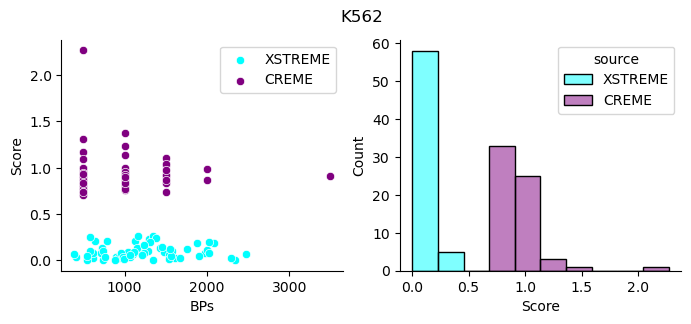

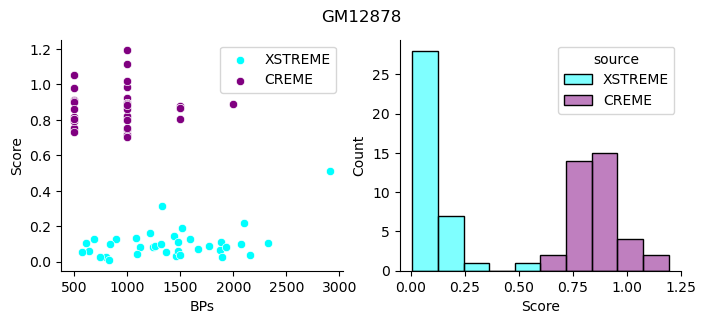

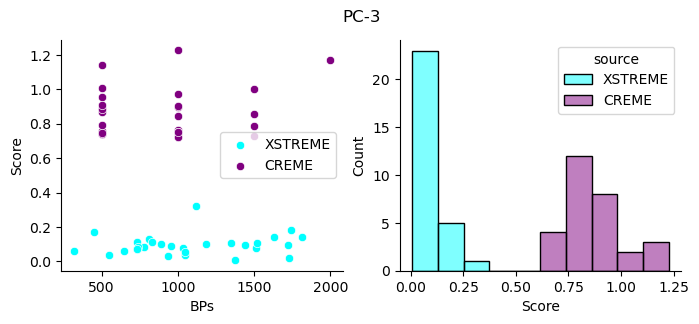

In [127]:
for cell_line in ['K562', 'GM12878', 'PC-3']:
    fig, axes = plt.subplots(1, 2, figsize=[8, 3])
    result_paths = glob.glob(f'../results/XSTREME/FIMO/{cell_line}_enhancers_*//*pickle')
    my_scores = []
    my_bps = []
    xstreme_scores = []
    xstreme_bps = []
    for res_path in result_paths:
        res = utils.read_pickle(res_path)
        prune_res = utils.read_pickle(f"{result_dir}/{cell_line}/{res_path.split('/')[-1]}")
        xstreme_scores.append(res['motifs'] / prune_res['mut'])
        xstreme_bps.append(np.sum(res['motif_mask']))
        if len(prune_res[50]['scores']) > 1:
            my_scores.append(prune_res[50]['scores'][-2])
            my_bps.append(prune_res[50]['bps'][-2])
        else:
            my_scores.append(prune_res[500]['scores'][-2])
            my_bps.append(prune_res[500]['bps'][-2])
    sns.scatterplot(x=xstreme_bps, y=xstreme_scores, color='cyan', label='XSTREME', ax=axes[0])
    sns.scatterplot(x=my_bps, y=my_scores, color='purple', label='CREME', ax=axes[0])
    axes[0].set_xlabel('BPs')
    axes[0].set_ylabel('Score')
    dfs = []
    for label, score in [['XSTREME', xstreme_scores], ['CREME', my_scores]]:
        df = pd.DataFrame([score]).T
        df.columns=['score']
        df['source'] = label
        dfs.append(df)
    sns.histplot(data=pd.concat(dfs), x='score', hue='source', bins=10, palette={'XSTREME': 'cyan', 'CREME': 'purple'}, ax=axes[1])

    axes[1].set_xlabel('Score')


    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.legend()
    fig.suptitle(cell_line)
    
    fig.savefig(f"{pdf_dir}/XSTRME_vs_CREME_{cell_line}.pdf")
    plt.show()

# CREME vs Saliency vs XSTREME

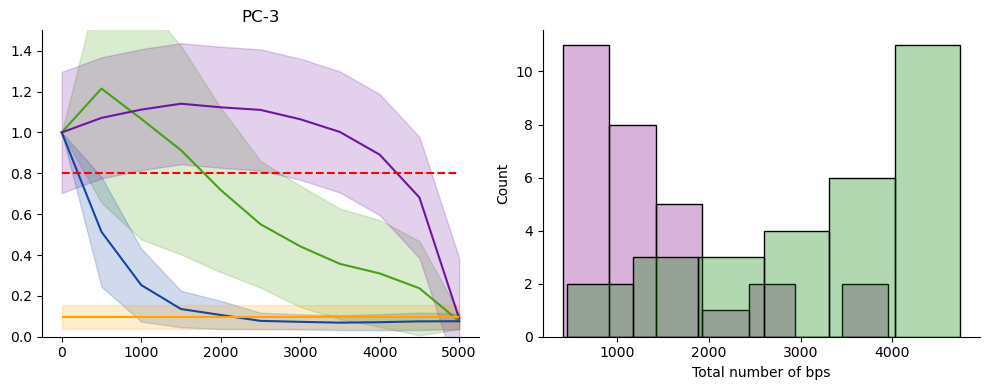

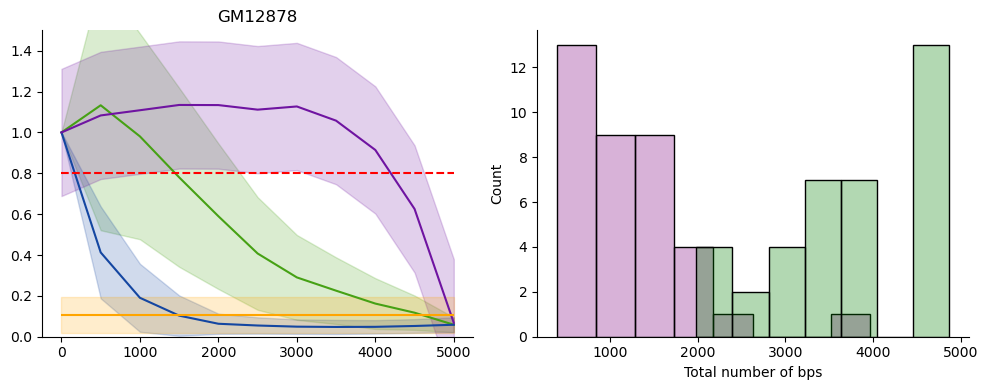

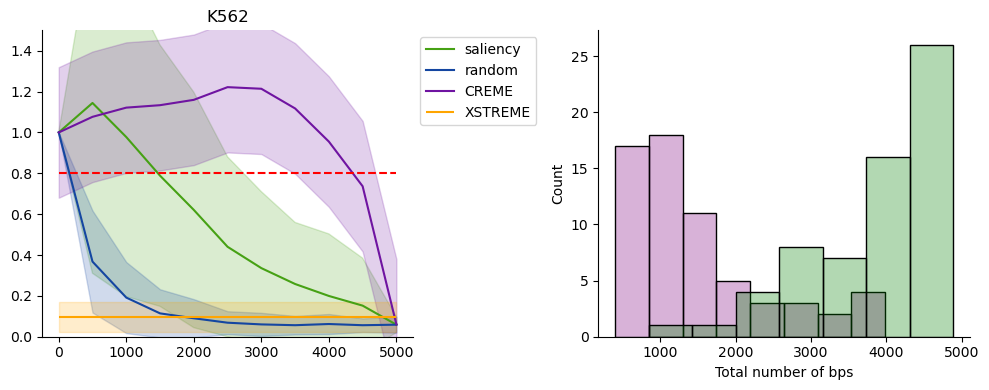

In [128]:
threshold_for_plotting = 0.8
c = ['#46a114', '#1446a1', '#a16f14']
saliency_and_control = ['saliency', 'random']
for a, (index, cell_line) in enumerate({4824: 'PC-3', 5110: 'GM12878', 5111: 'K562'}.items()):
    fig, axes = plt.subplots(1, 2, figsize=[10, 4])

    ax = axes[0]
    bps = np.arange(0, 5001, 500)
    mean_set = {k:[] for k in saliency_and_control}
    mean_set_CREME = []
    xstreme_scores = []
    bps_at_thresh = {'saliency': [], 'CREME': []}
    for s, seq_tile_id in enumerate(os.listdir(f'{saliency_dir}/{index}/')): 
        xstreme_res = utils.read_pickle(glob.glob(f'../results/XSTREME/FIMO/{cell_line}_enhancers_*/{seq_tile_id}')[0])
        saliency_res = utils.read_pickle(f'{saliency_dir}/{index}/{seq_tile_id}')
        prune_res = utils.read_pickle(f'{result_dir}/{cell_line}/{seq_tile_id}')
        
        frac = np.array([1] + prune_res[500]['scores'][:-1] + prune_res[50]['scores'])
        mean_set_CREME.append(frac) # save to compute mean line
        
        # Saliency results
        for i, label in enumerate(saliency_and_control):
            scores = saliency_res[label]
            norm_scores = np.array(scores) / prune_res['mut']
            mean_set[label].append(norm_scores) 
        #XSTREME results
        
        xstreme_scores.append(xstreme_res['motifs'] / prune_res['mut'])
        bps_at_thresh['saliency'].append(5000 - interp1d(saliency_res['saliency']/ prune_res['mut'], bps)(threshold_for_plotting))
        bps_at_thresh['CREME'].append(5000-interp1d(frac, bps[:len(frac)])(threshold_for_plotting))
        
        
        
        
    longest_i = np.argmax([len(l) for l in mean_set_CREME])

    mean_set_CREME = np.array([np.pad(a, mode='constant',constant_values=(np.nan,),
                                      pad_width=(0, len(mean_set_CREME[longest_i])-len(a))) for a in mean_set_CREME])
    mean_set_CREME = np.nanmean(mean_set_CREME, axis=0)
    std_set_CREME = np.nanstd(mean_set_CREME, axis=0)

    for j, (k, v) in enumerate(mean_set.items()):
        mean = np.array(v).mean(axis=0)
        std = np.array(v).std(axis=0)
        ax.fill_between(bps, mean-std, mean+std, color=c[j], alpha=.2)
        ax.plot(bps, np.array(v).mean(axis=0), label=k, color=c[j])
        


    
    ax.plot(np.arange(0, 5500, 500), mean_set_CREME, label='CREME', color='#6f14a1')
    ax.fill_between(np.arange(0, 5500, 500), mean_set_CREME-std_set_CREME, mean_set_CREME+std_set_CREME, color='#6f14a1', alpha=.2)
    ax.hlines(threshold_for_plotting, 0, 5000, linestyle='--', color='r')
    # ax.hlines(thresholds[1], 0, 5000, linestyle='--', color='r', label='CREME threshold 50bp')
    xstreme_mean = np.mean(xstreme_scores)
    xstreme_std = np.std(xstreme_scores)

    ax.hlines(xstreme_mean, 0, 5000, color='orange', label='XSTREME')
    ax.fill_between(np.arange(0, 5500, 500), xstreme_mean-xstreme_std, xstreme_mean+xstreme_std, color='orange', alpha=.2)
    if a==2:
        ax.legend(bbox_to_anchor=[1,1])
    ax.set_title(cell_line)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_xlim(0, 4500)
    ax.set_ylim(0, 1.5)
    
    sns.histplot(bps_at_thresh['CREME'], color='purple', ax=axes[1], alpha=0.3)
    sns.histplot(bps_at_thresh['saliency'], color='green', ax=axes[1], alpha=0.3)

    plt.xlabel('Total number of bps')
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    plt.tight_layout()
    fig.savefig(f"{pdf_dir}/average_traces_{cell_line}.pdf")
    plt.show()


# Example sequence

In [62]:
model = custom_model.Enformer()
seq_parser = utils.SequenceParser('../data/GRCh38.primary_assembly.genome.fa')


2024-02-14 05:53:59.220975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-14 05:53:59.562376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79005 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:07:00.0, compute capability: 8.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:30<00:00,  1.06s/it]


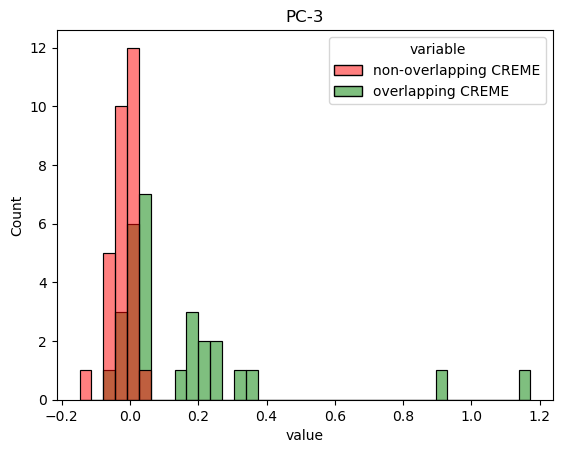

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:39<00:00,  1.07s/it]


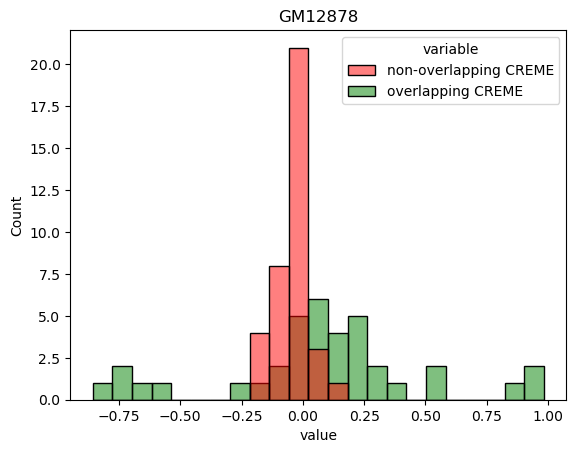

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:08<00:00,  1.08s/it]


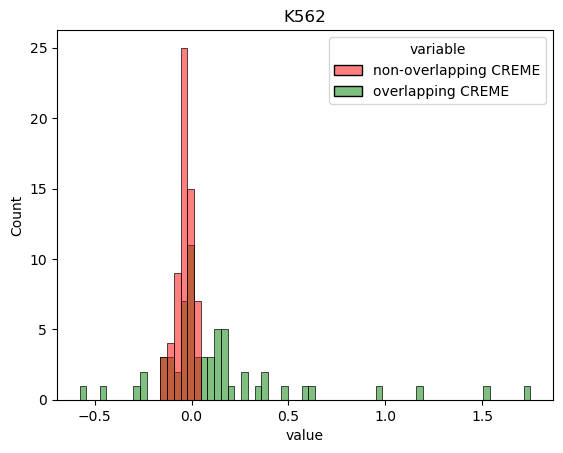

In [129]:
for a, (index, cell_line) in enumerate({4824: 'PC-3', 5110: 'GM12878', 5111: 'K562'}.items()):
    
    average_saliency_vals = []
    for filename in tqdm(os.listdir(f'../results/saliency/{index}/')):
        cre_saliency_scores, creme_mask = utils.get_saliency_and_creme_mask_overlap(filename,
                                                                                    model, seq_parser, cell_line, index)
        creme_mask = (creme_mask).astype(bool)
        average_saliency_vals.append([(cre_saliency_scores[~creme_mask]).numpy().mean(), (cre_saliency_scores[creme_mask]).numpy().mean()])
    average_saliency_vals = np.array(average_saliency_vals)
    df = pd.DataFrame(average_saliency_vals)
    df.columns = ['non-overlapping CREME', 'overlapping CREME']
    sns.histplot(data=df.melt(), x='value', hue='variable', palette=['r', 'g'])
    plt.title(cell_line)
    plt.savefig(f"{pdf_dir}/in_vs_out_saliency_{cell_line}.pdf")
    plt.show()

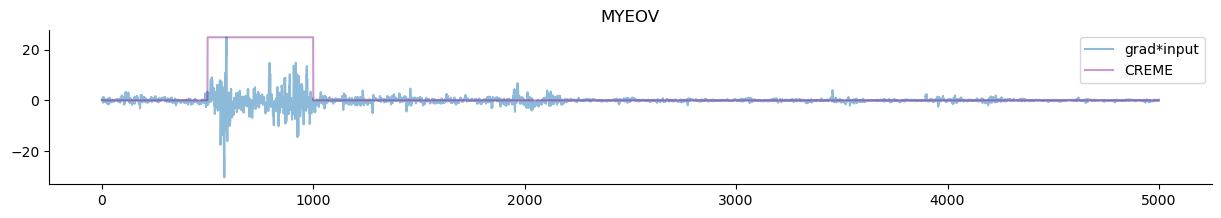

<Figure size 640x480 with 0 Axes>

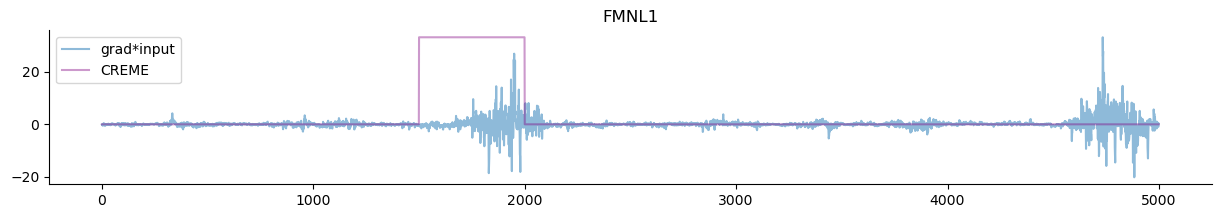

<Figure size 640x480 with 0 Axes>

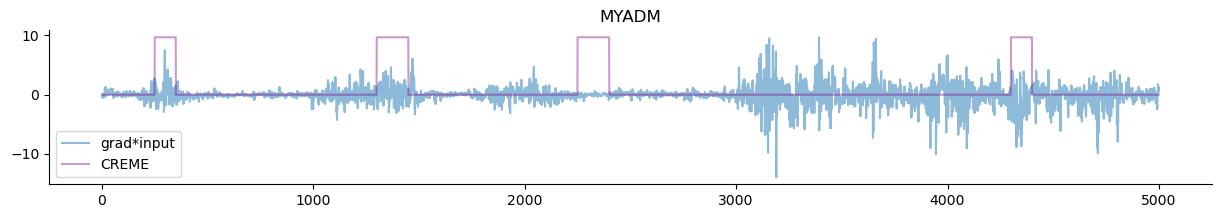

<Figure size 640x480 with 0 Axes>

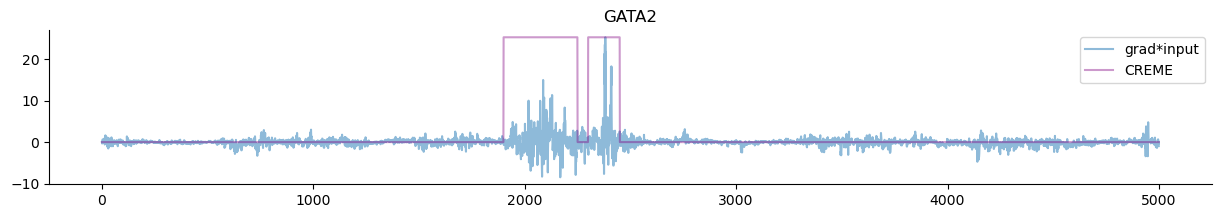

<Figure size 640x480 with 0 Axes>

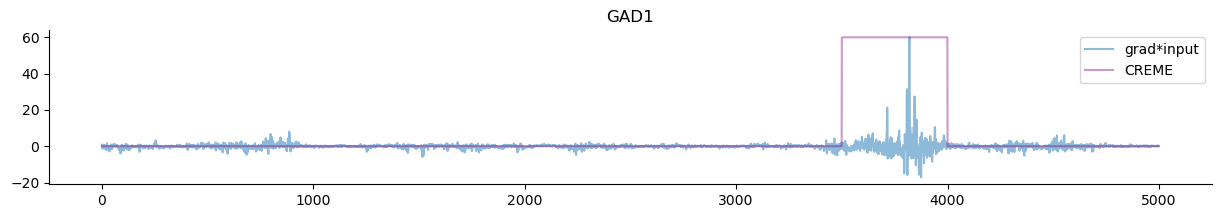

<Figure size 640x480 with 0 Axes>

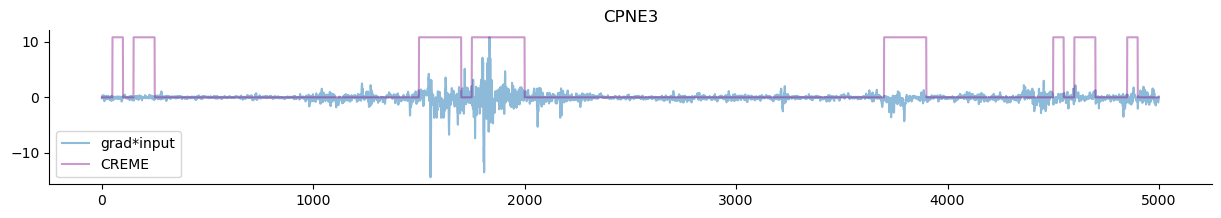

<Figure size 640x480 with 0 Axes>

In [130]:
for filename in os.listdir('../results/saliency/5111/'):
    if filename.split('_')[0] in ['GATA2', 'MYEOV', 'GAD1',
                                 'CPNE3', 'FMNL1', 'MYADM']:
        cre_saliency_scores, new_creme_mask = utils.plot_one_seq_feature_map(filename, model, seq_parser, 'K562', 5111, False)
        plt.savefig(f"{pdf_dir}/saliency_and_creme_{filename}.pdf")
        plt.show()

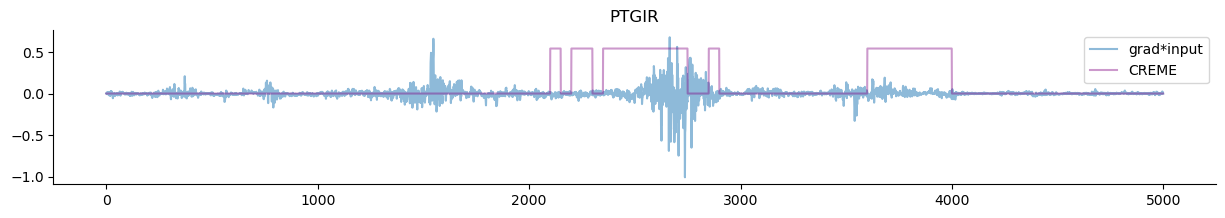

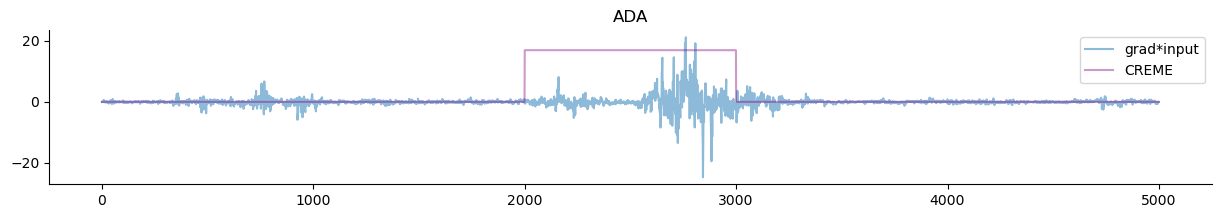

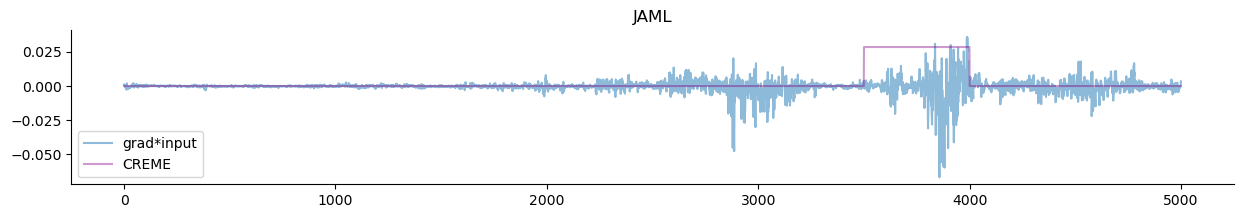

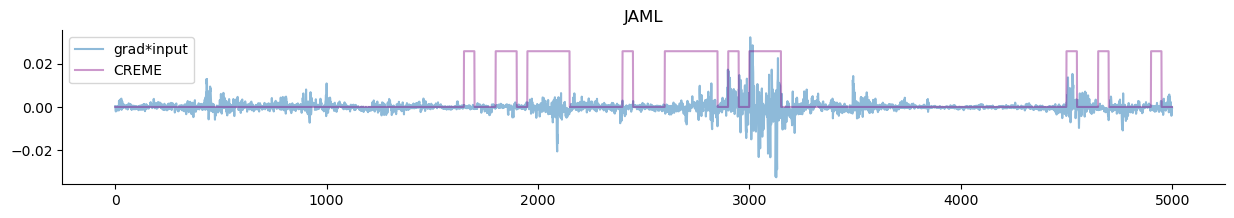

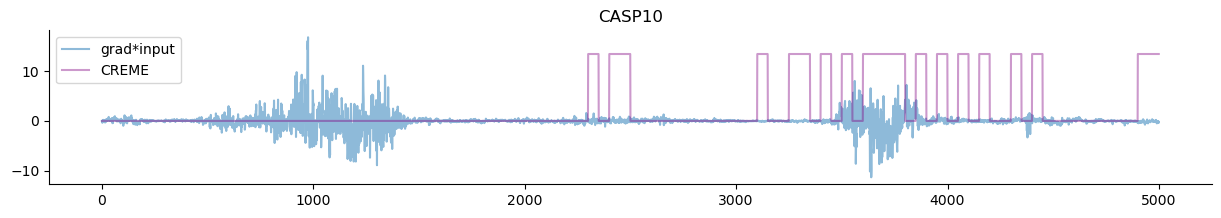

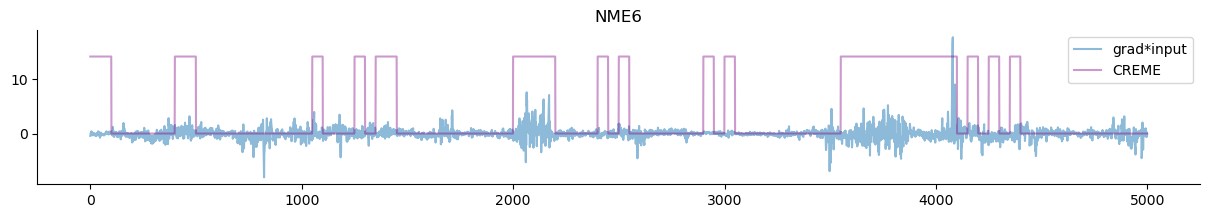

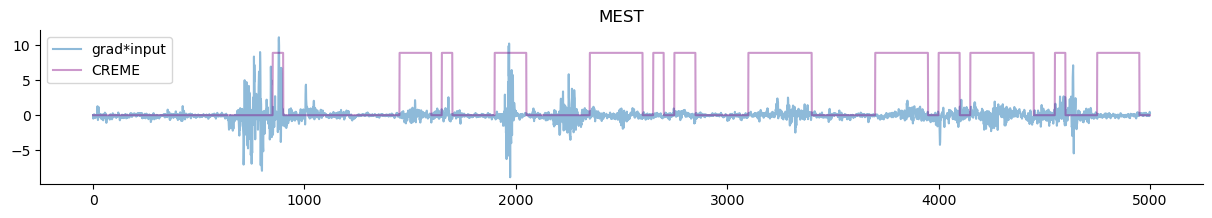

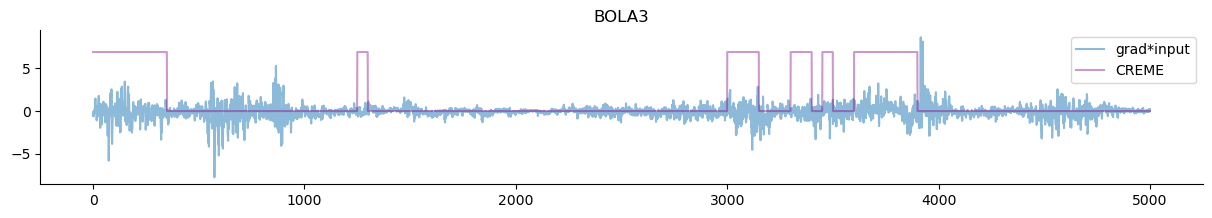

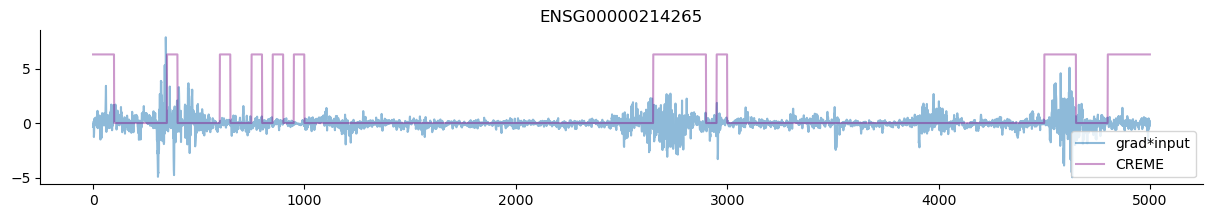

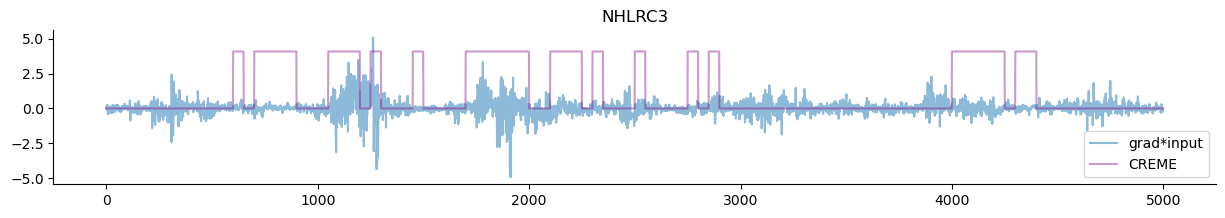

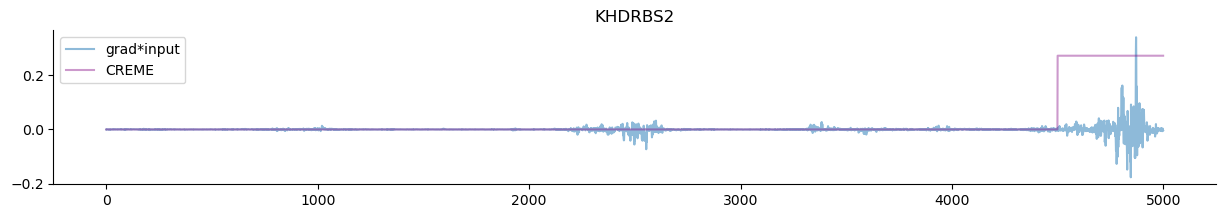

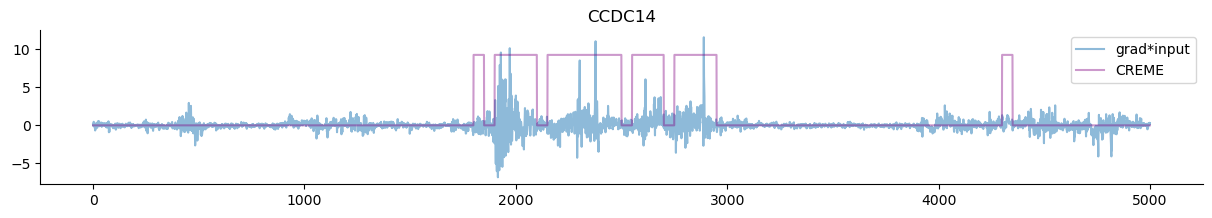

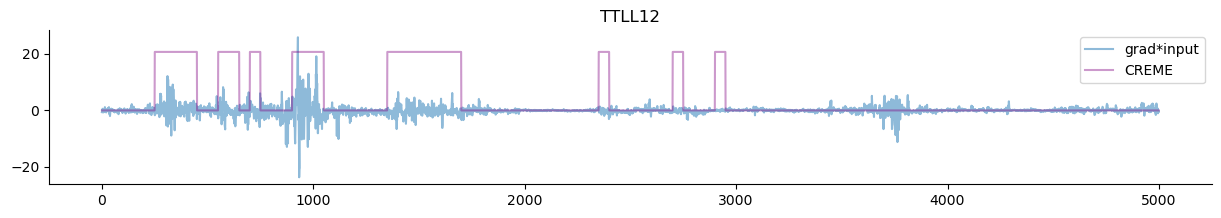

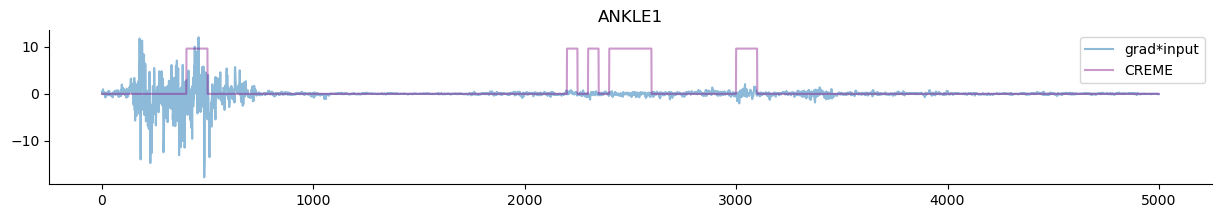

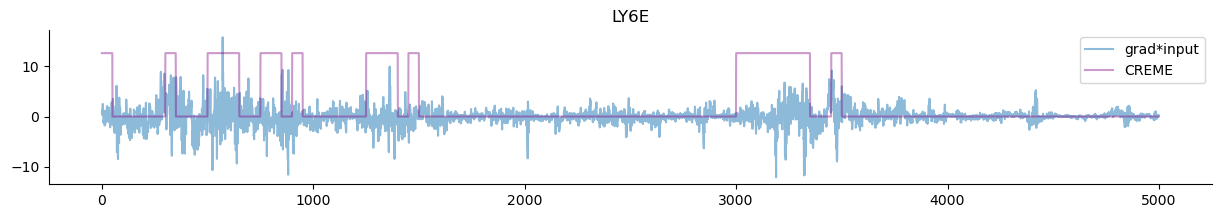

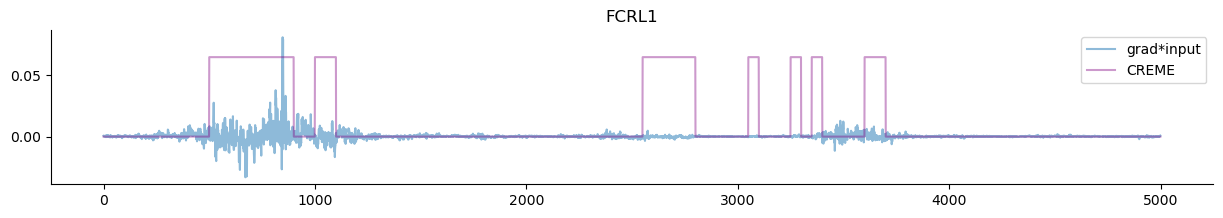

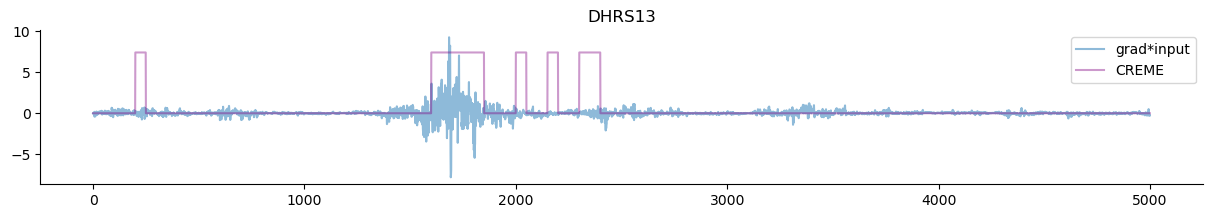

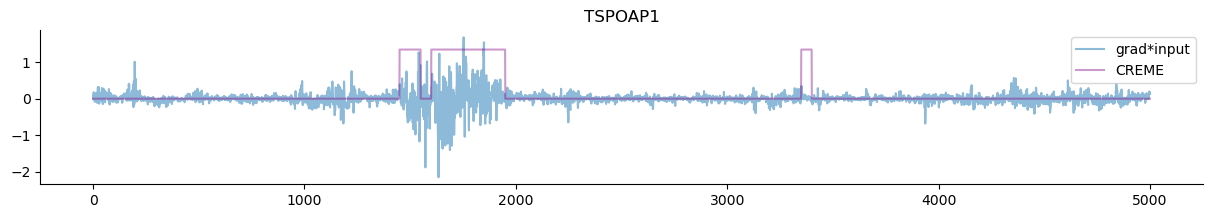

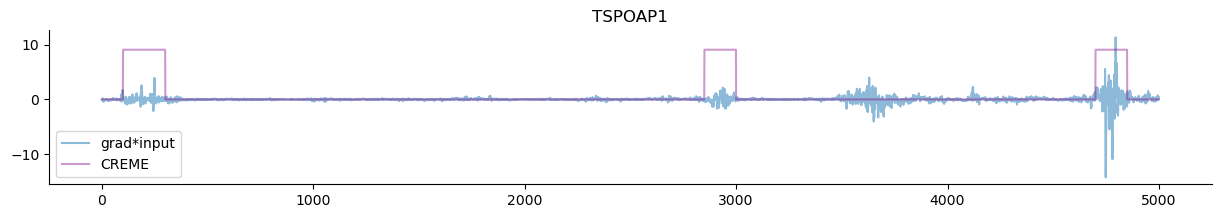

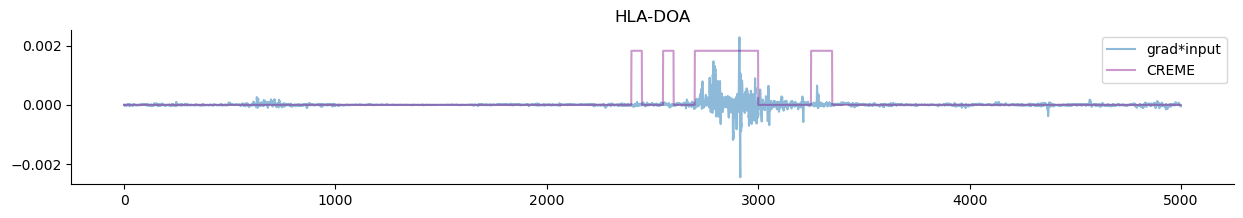

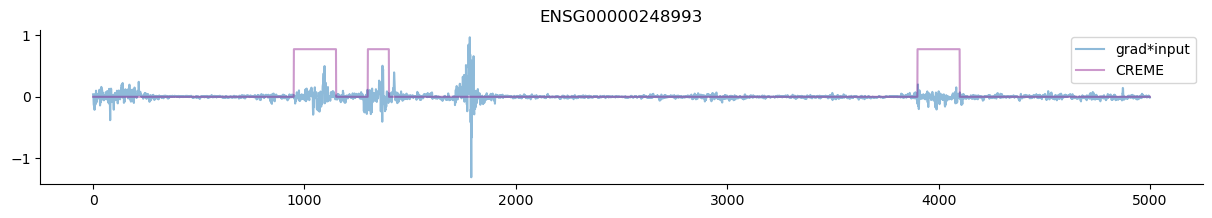

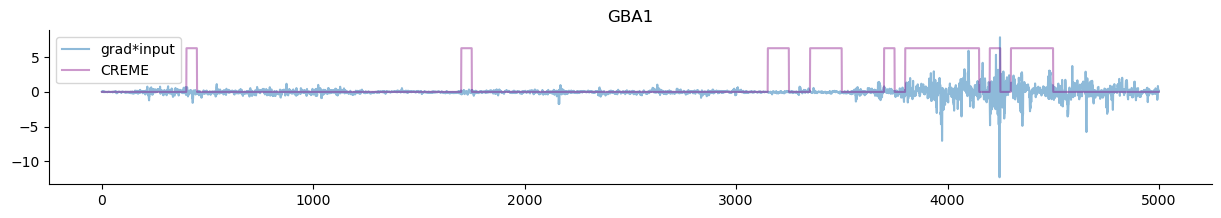

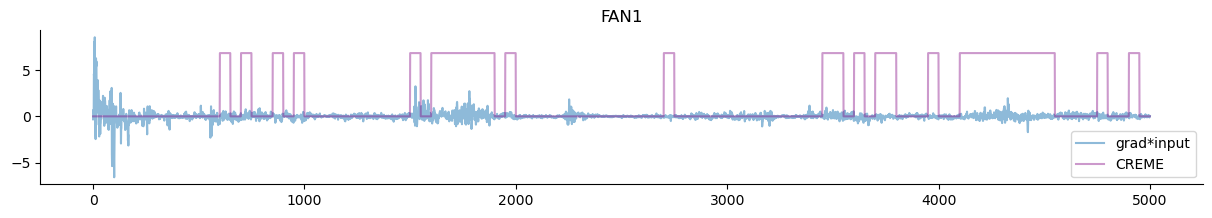

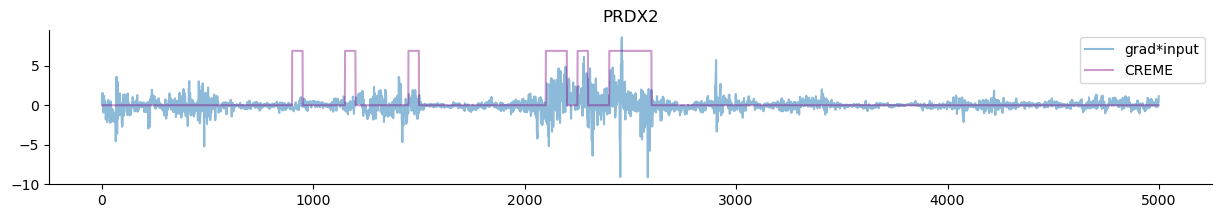

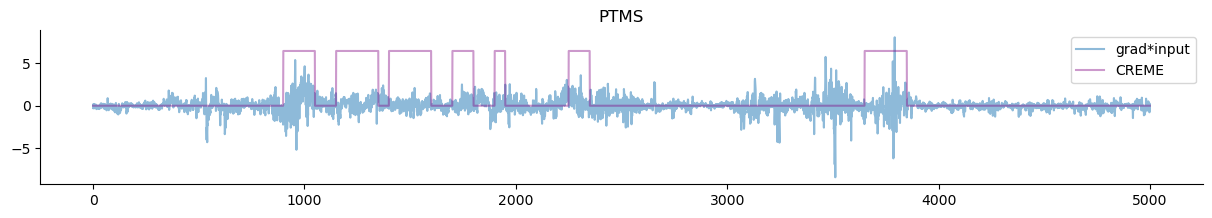

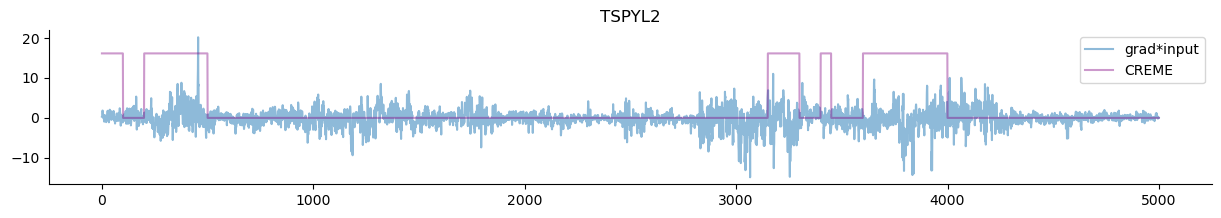

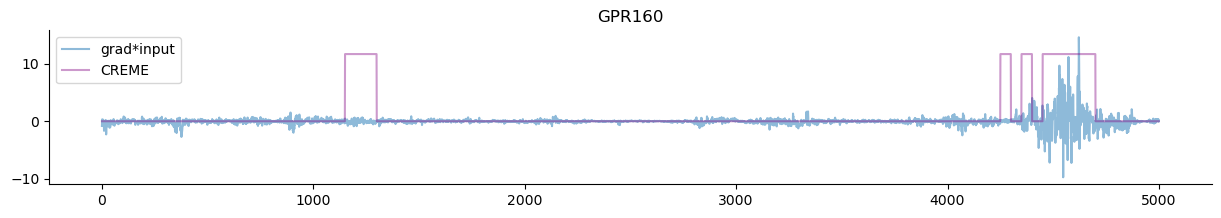

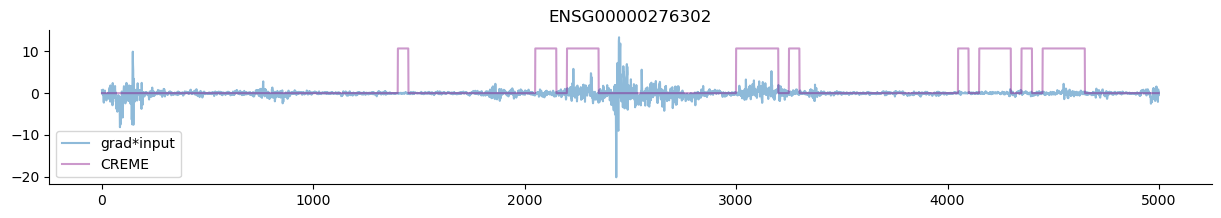

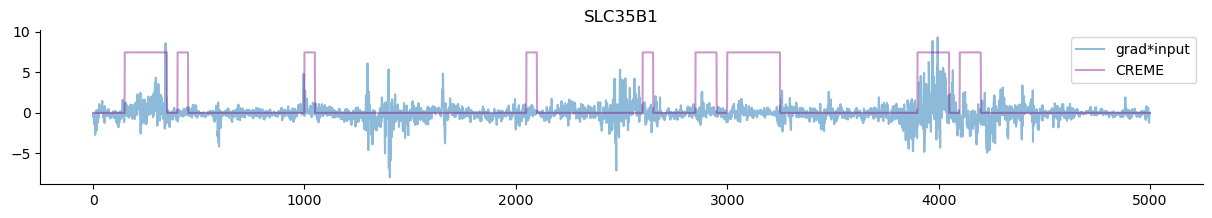

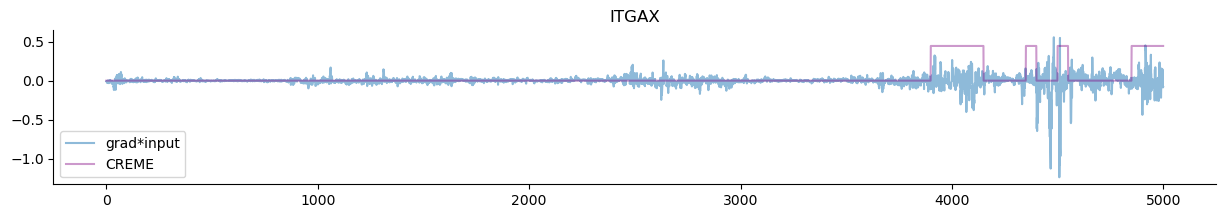

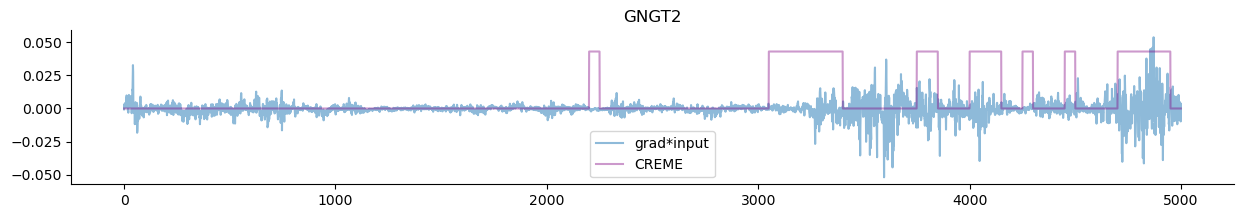

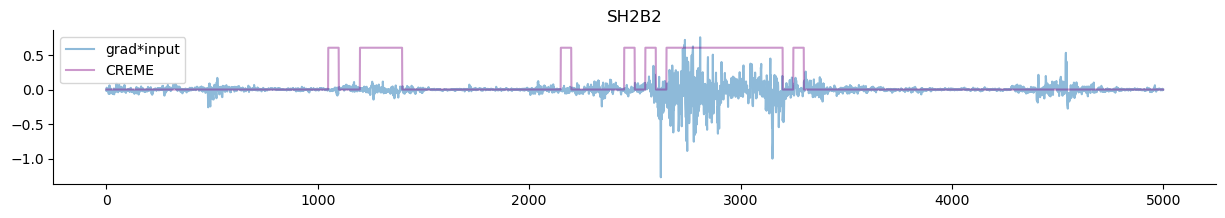

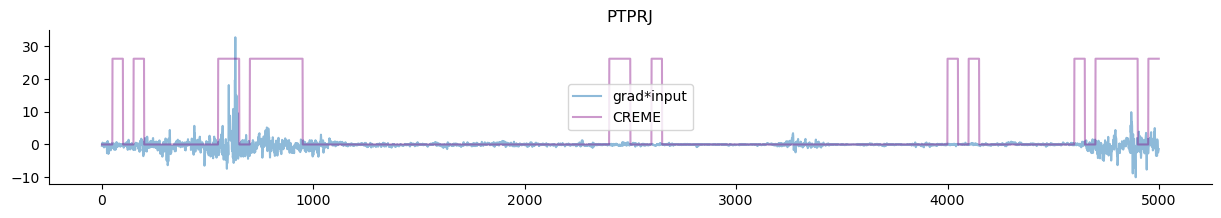

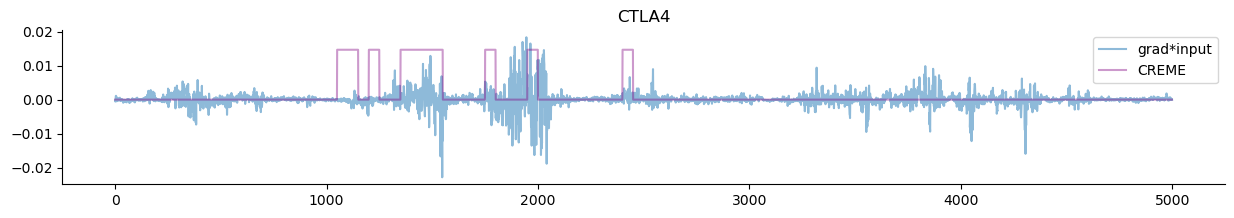

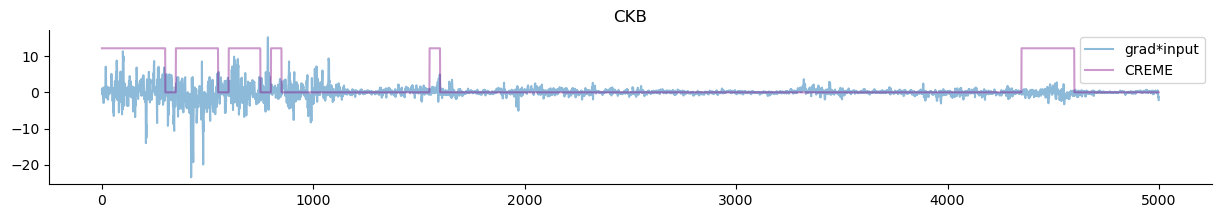

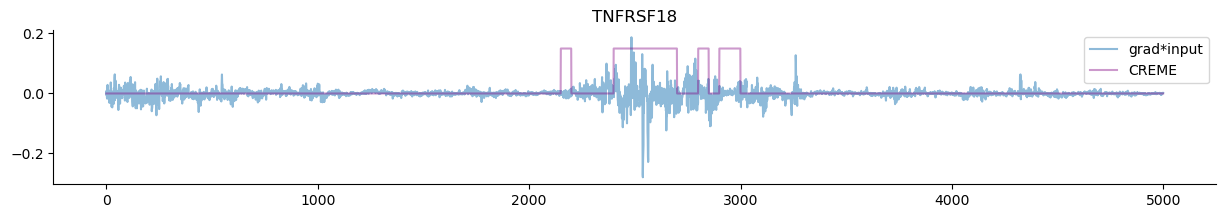

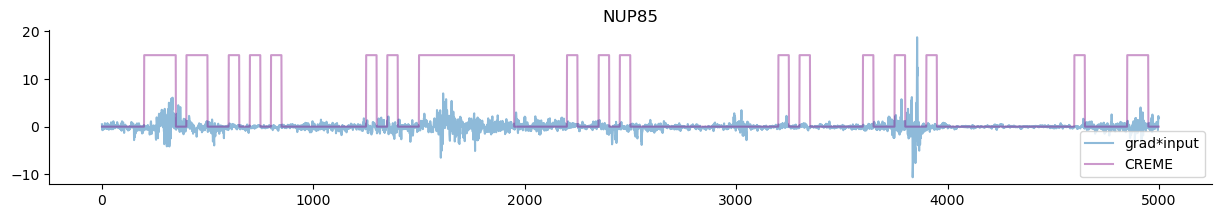

In [225]:
for filename in os.listdir('../results/saliency/5110/'):
    new_creme_mask = utils.plot_one_seq_feature_map(filename, model, seq_parser, 'GM12878', False)

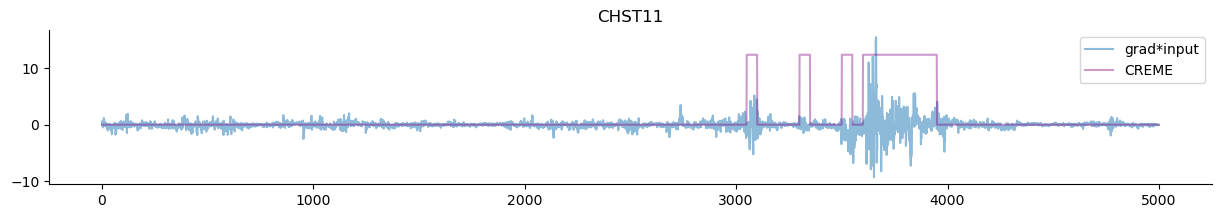

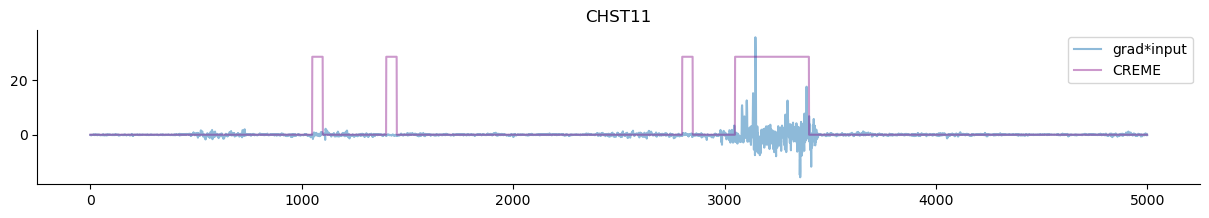

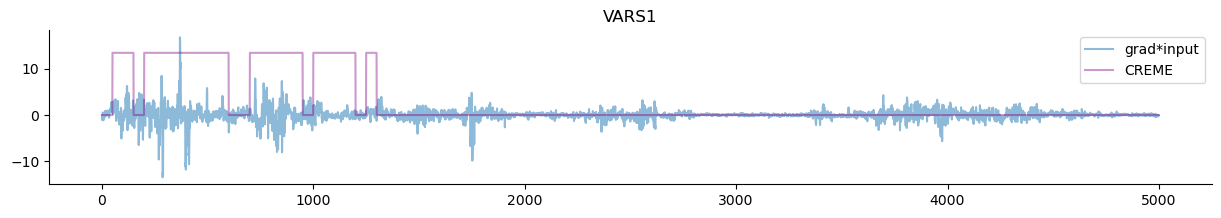

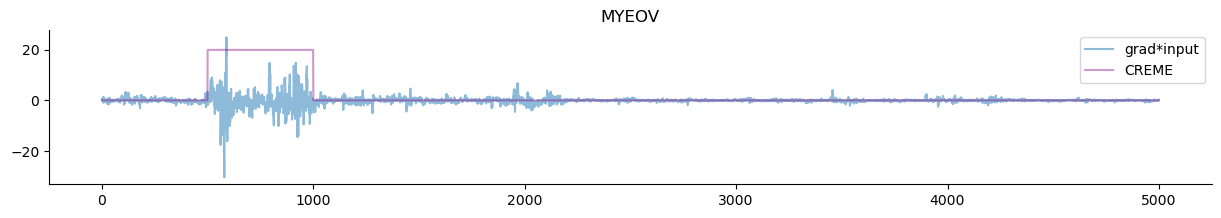

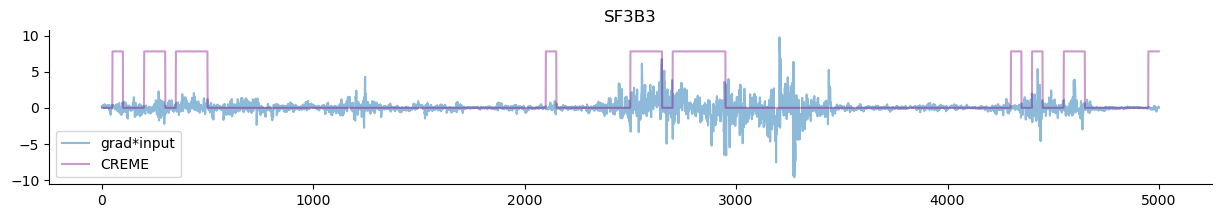

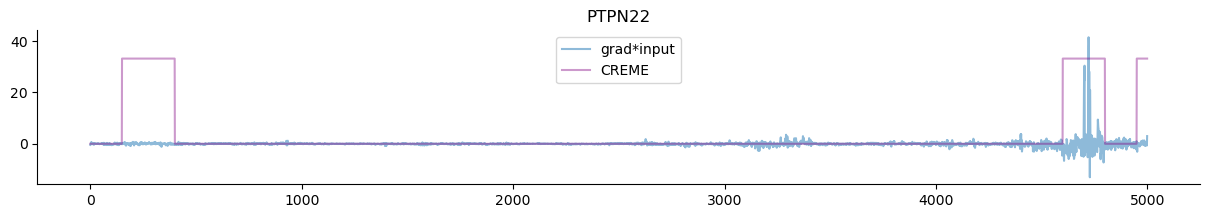

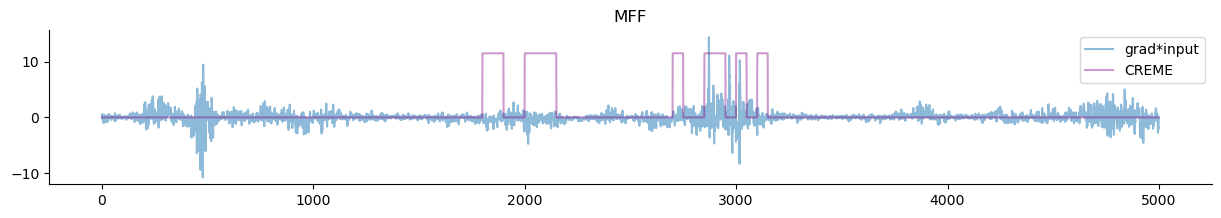

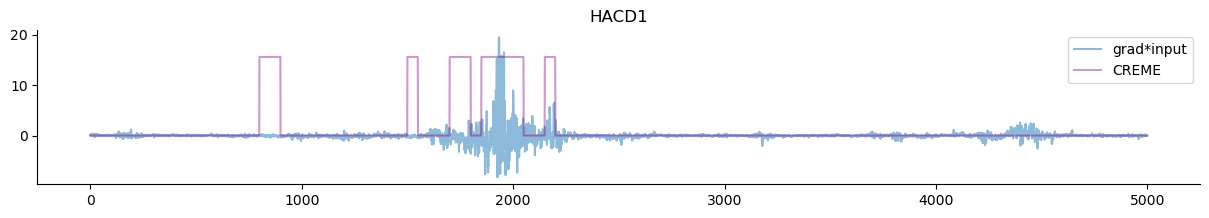

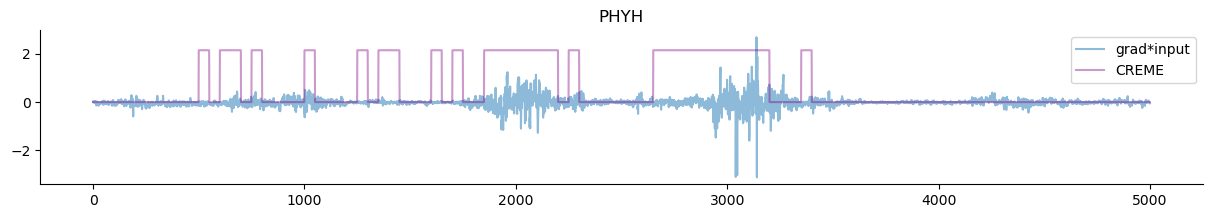

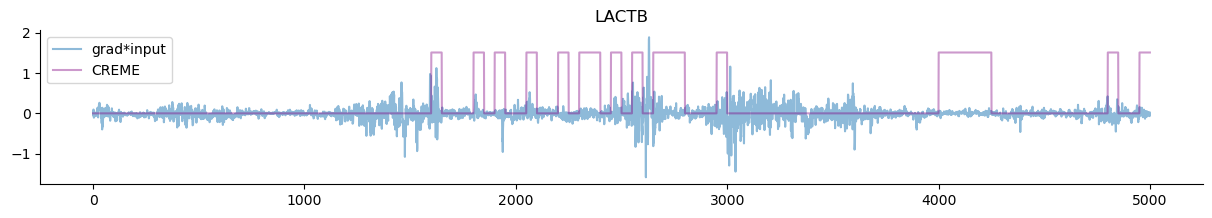

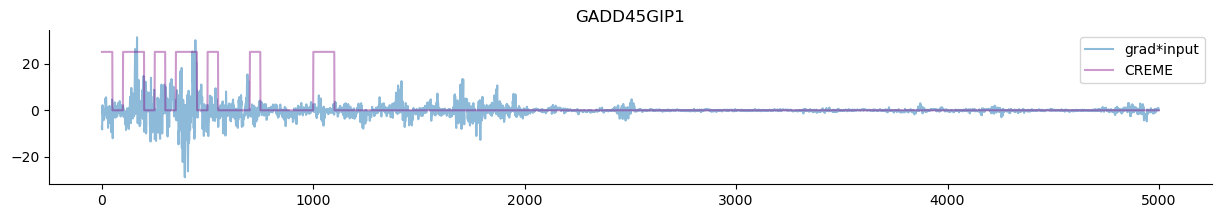

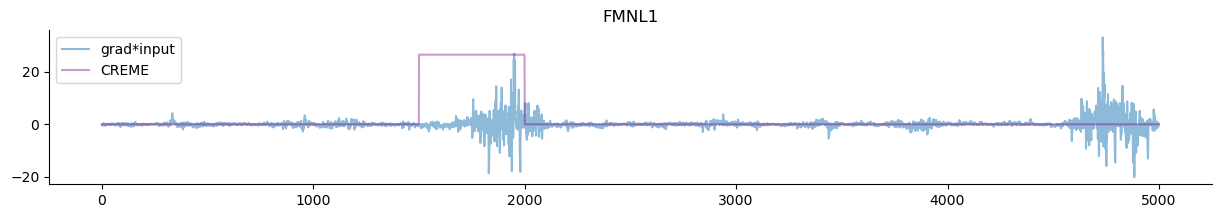

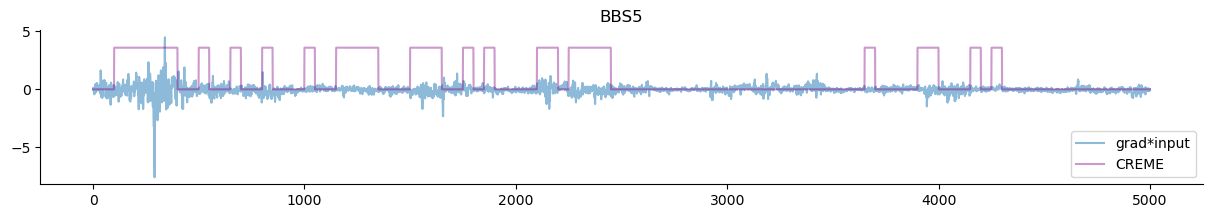

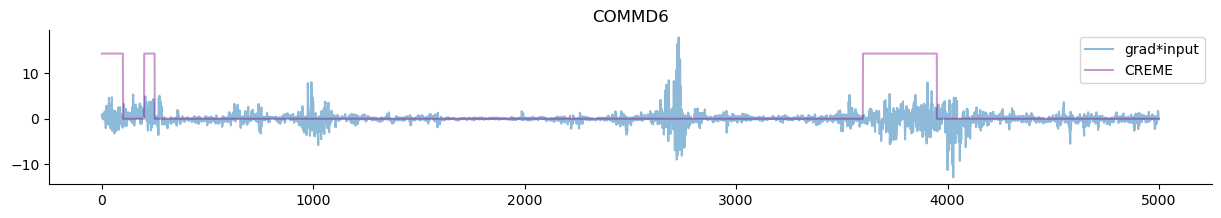

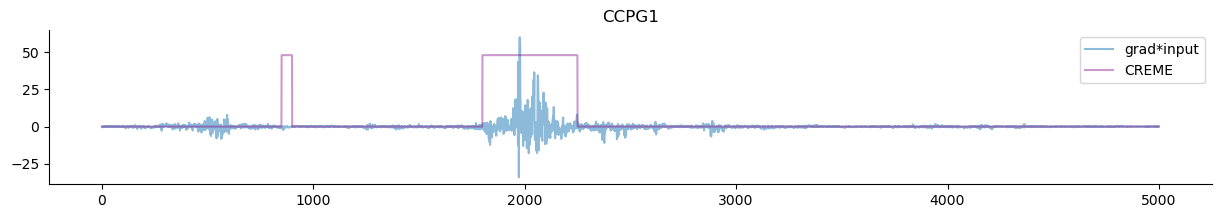

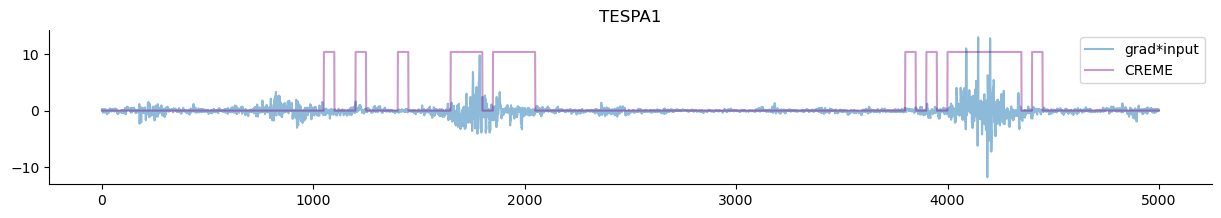

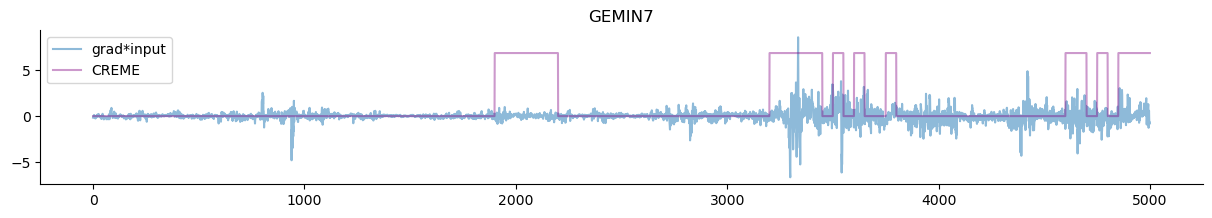

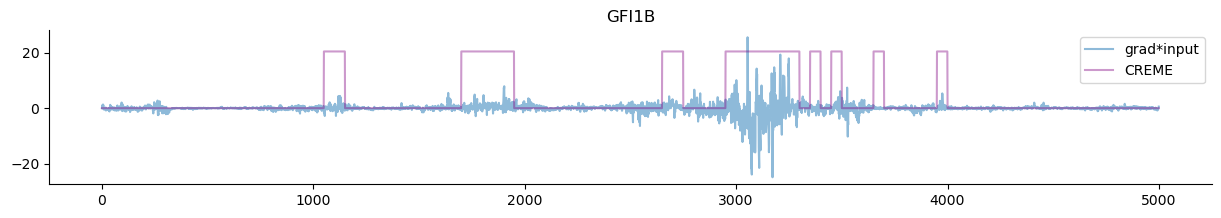

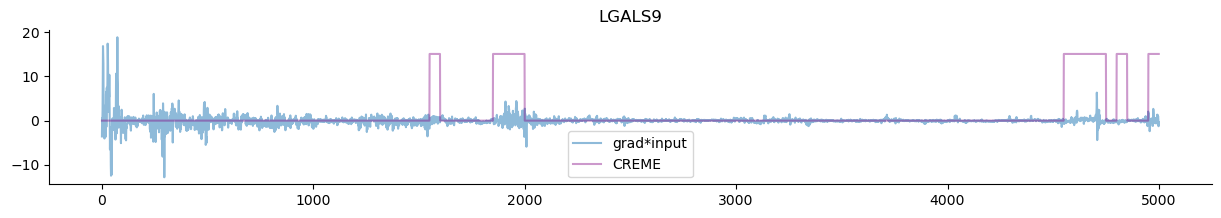

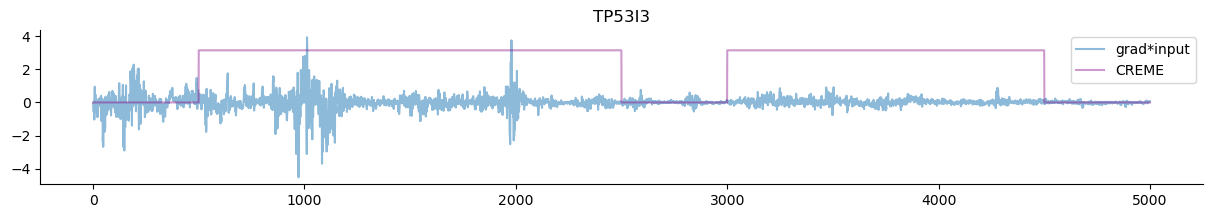

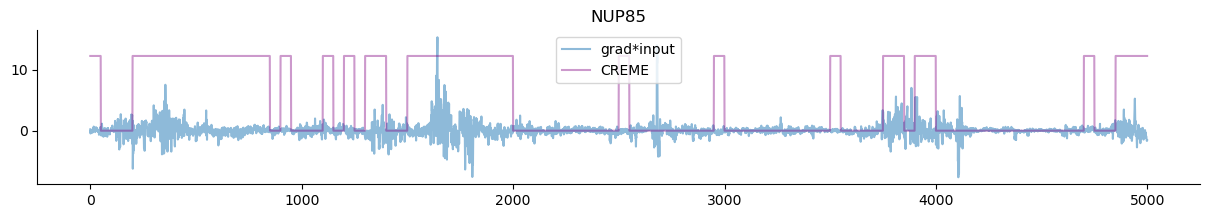

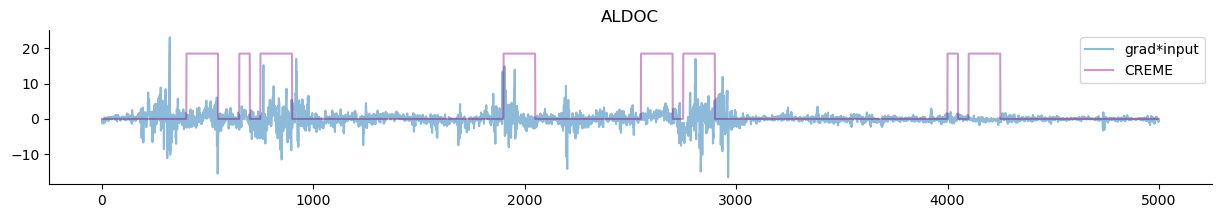

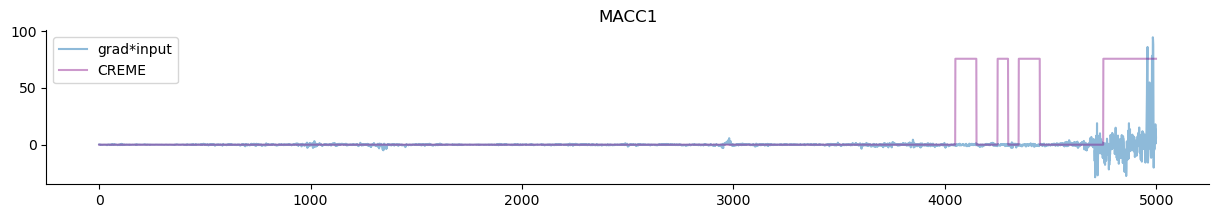

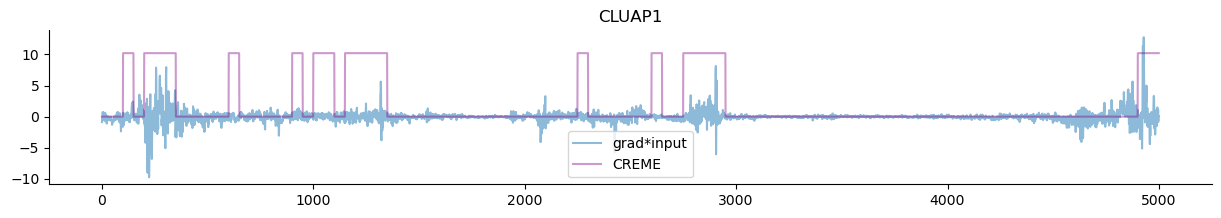

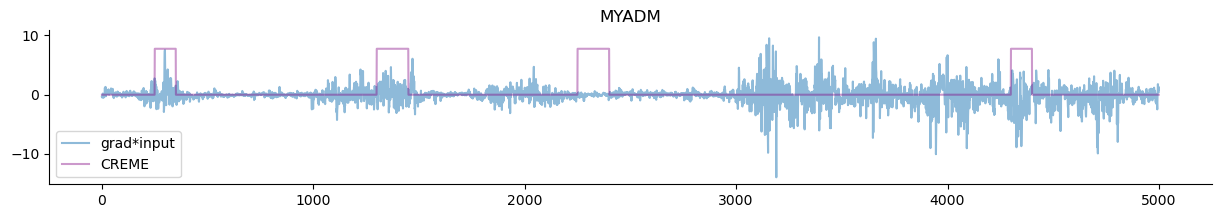

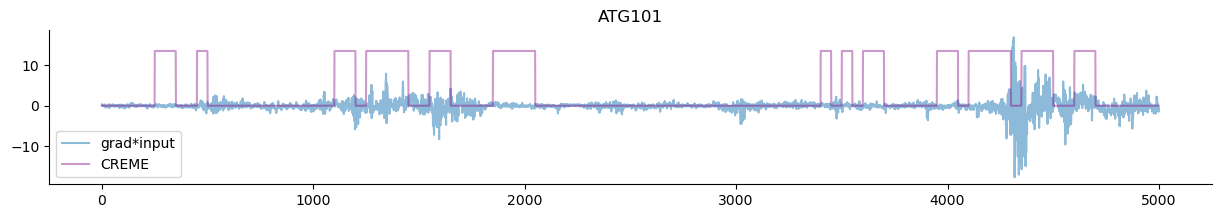

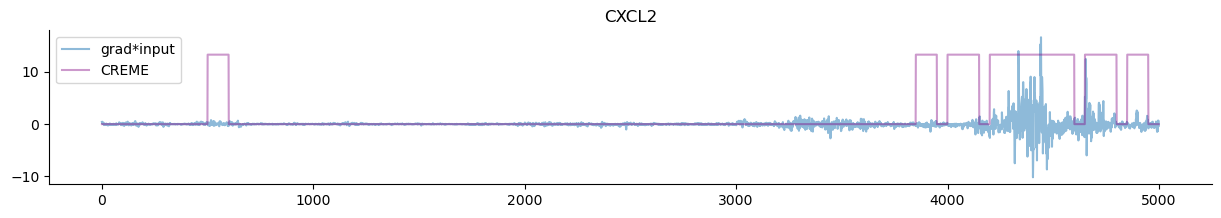

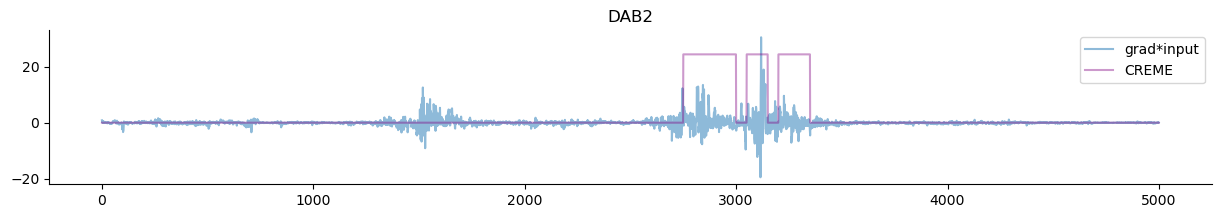

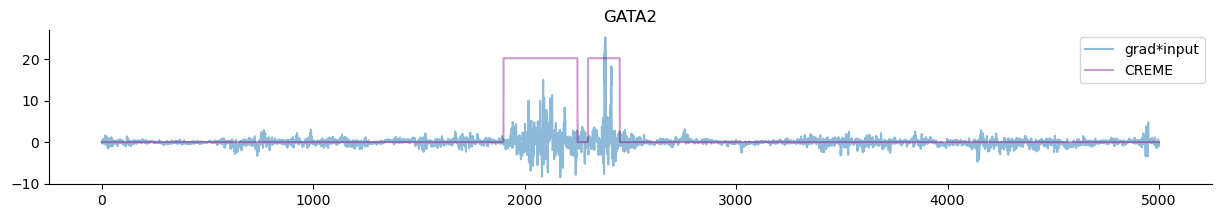

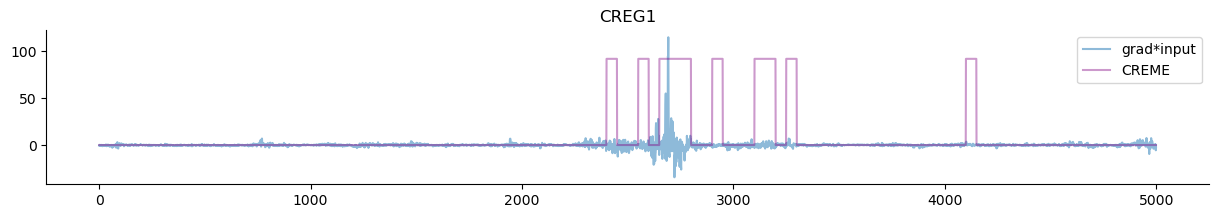

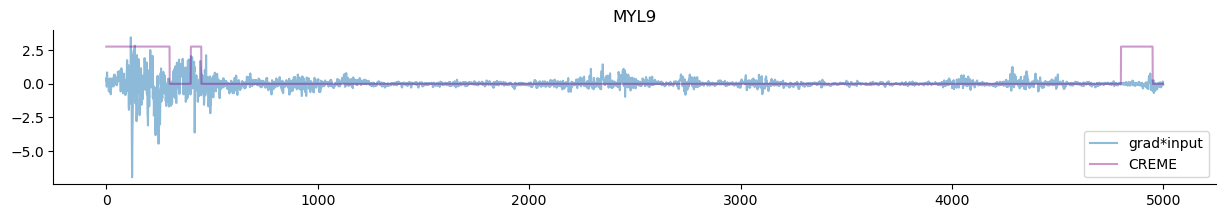

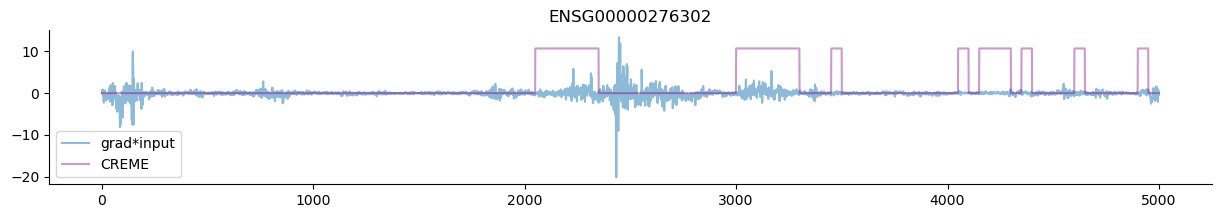

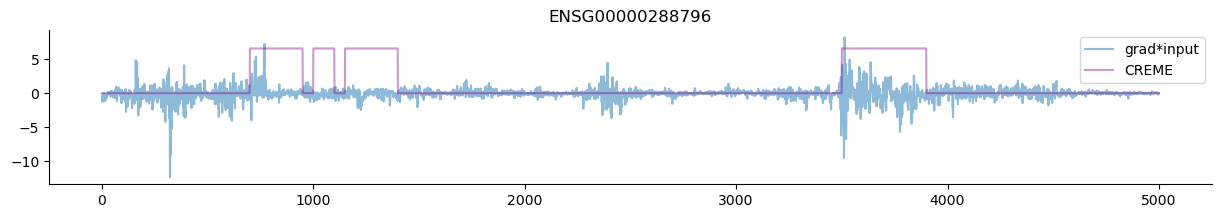

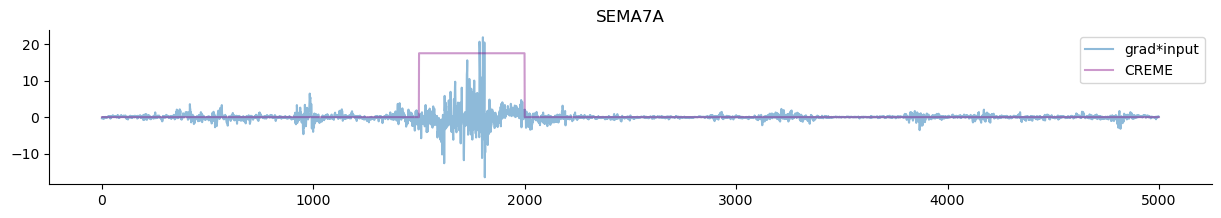

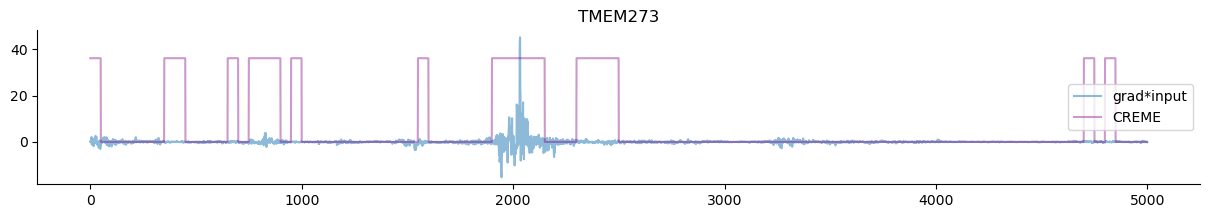

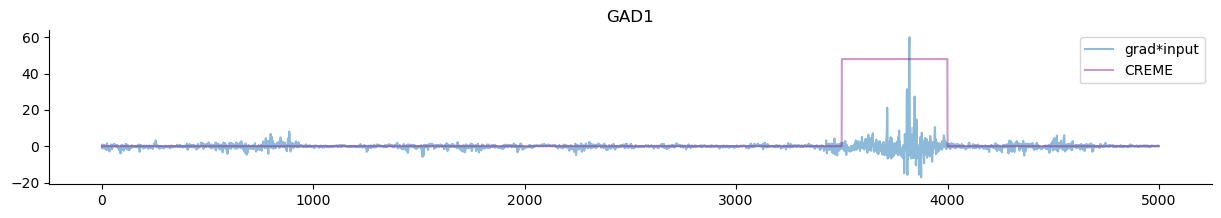

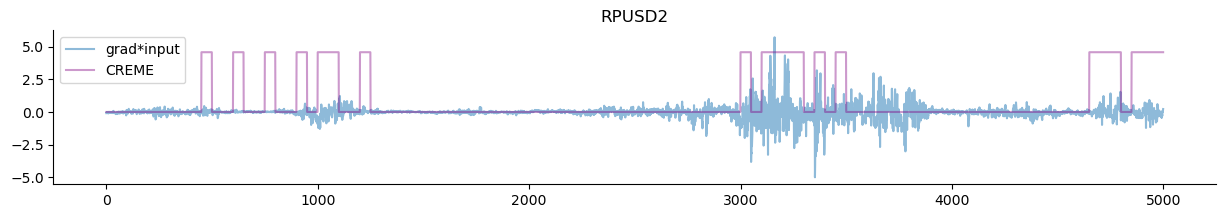

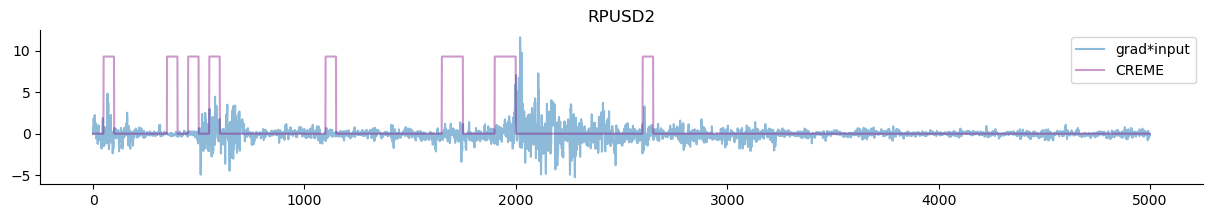

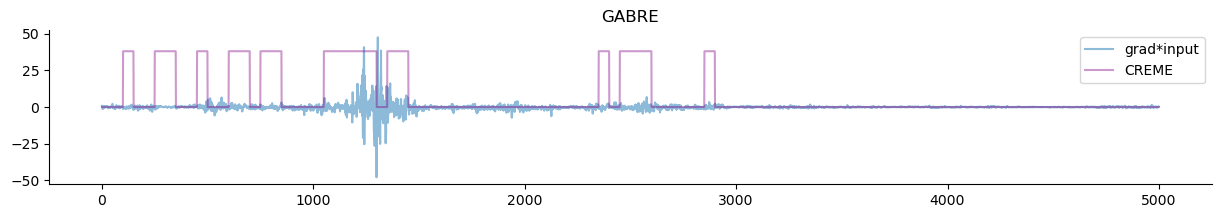

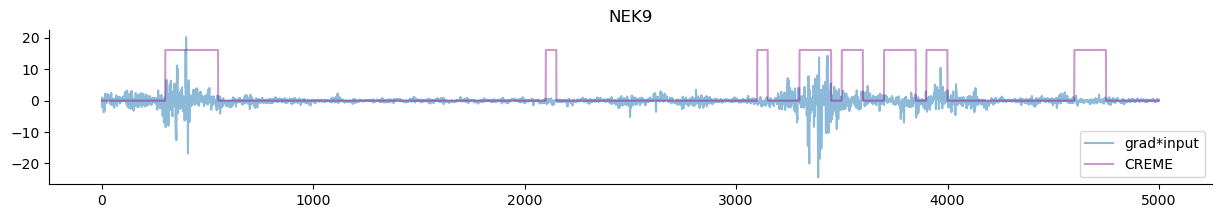

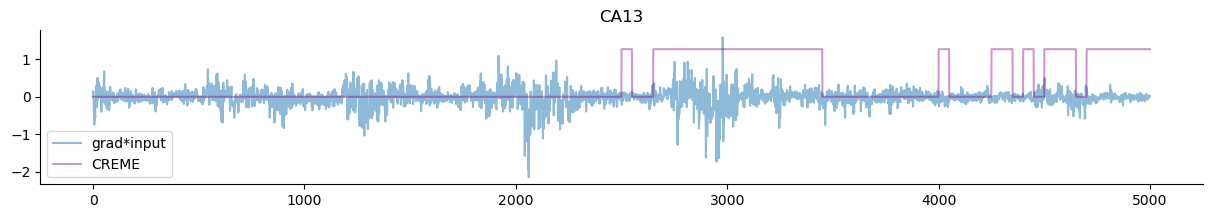

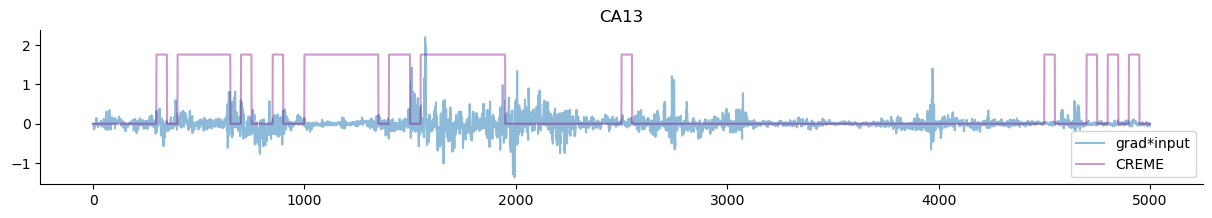

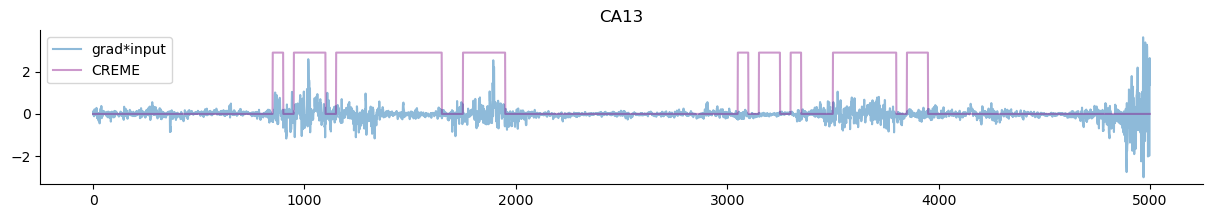

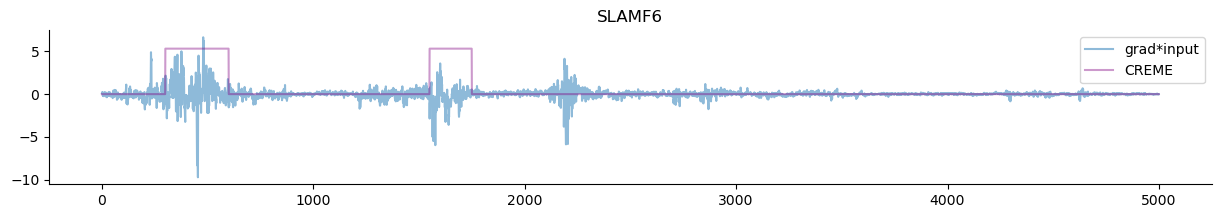

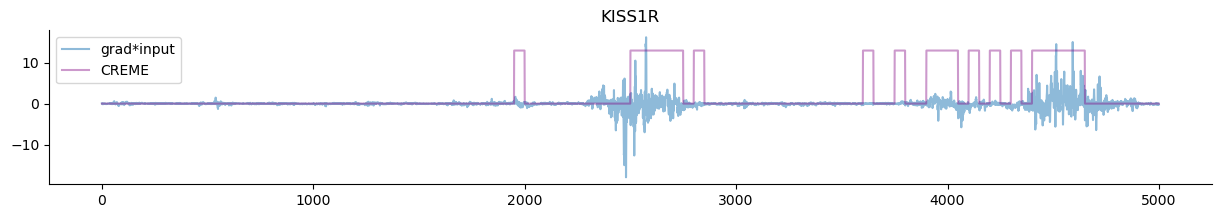

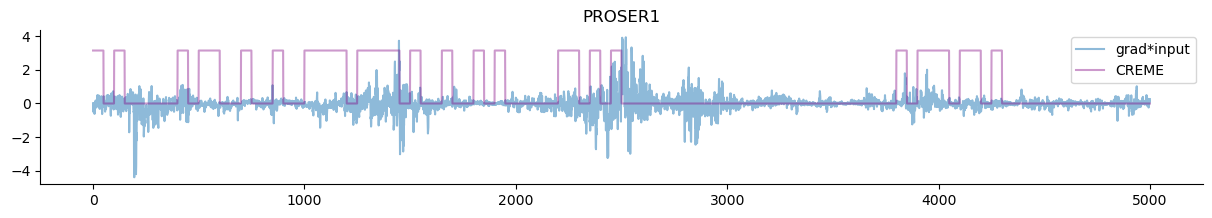

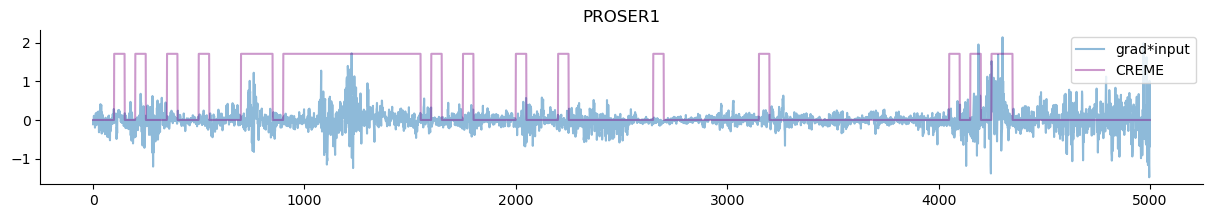

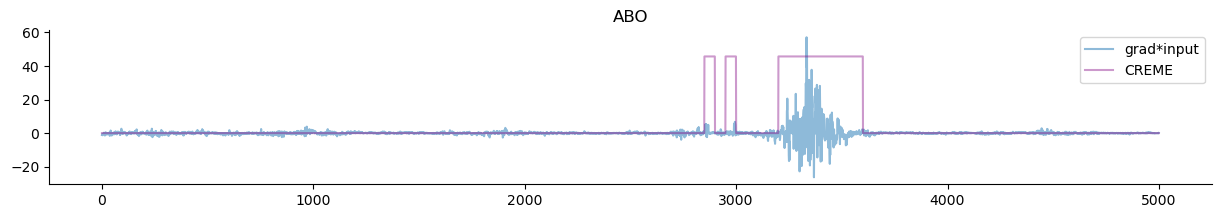

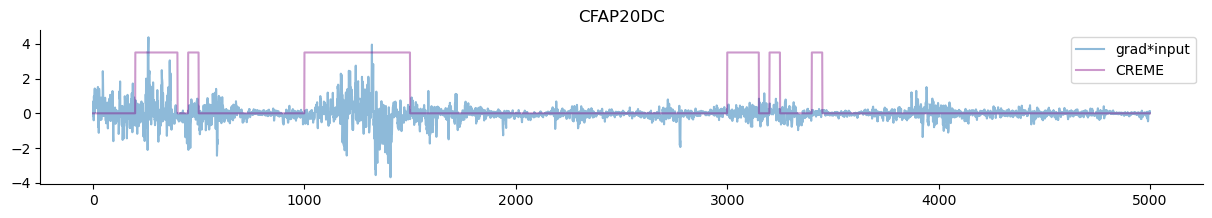

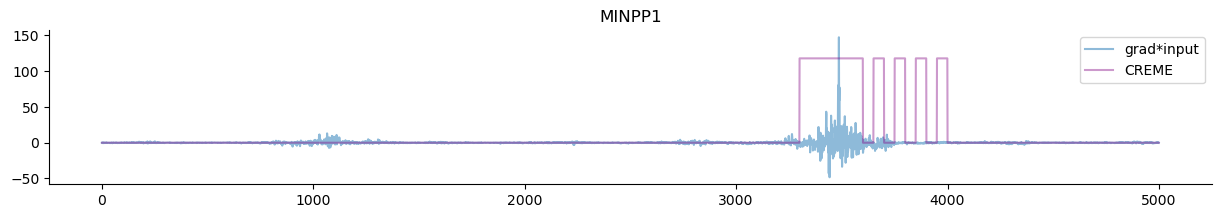

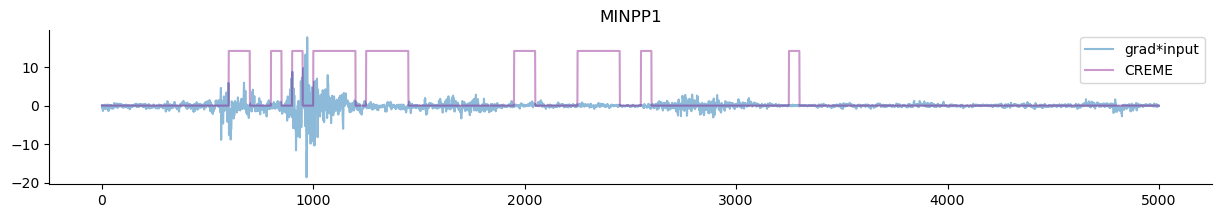

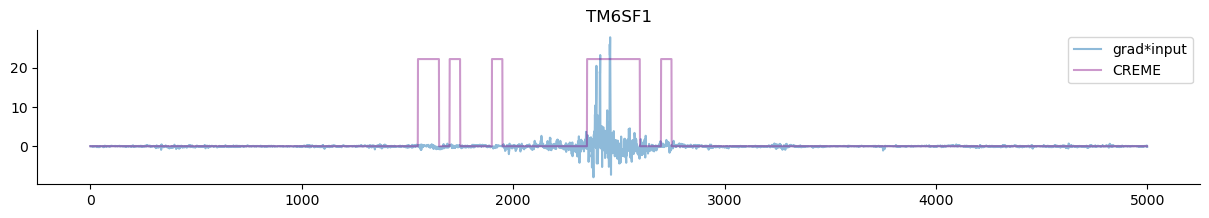

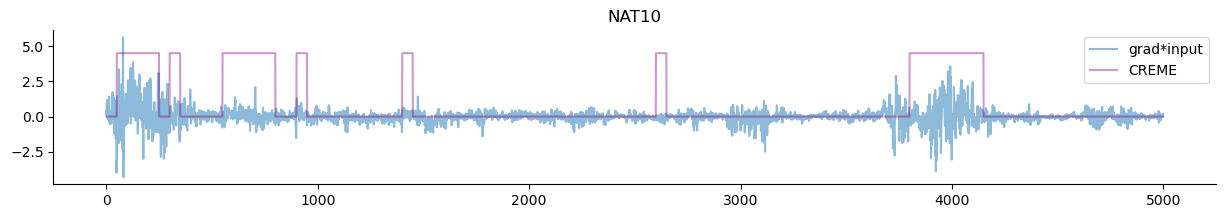

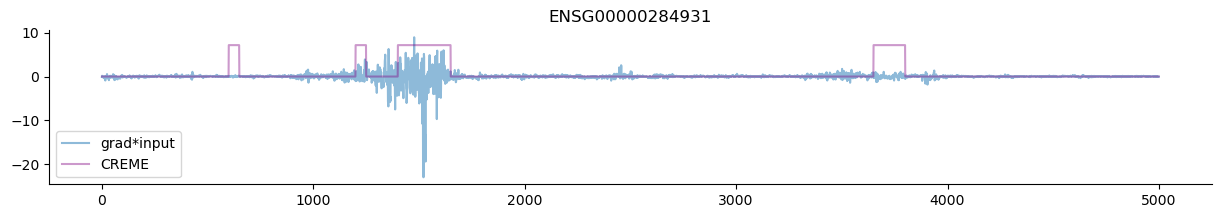

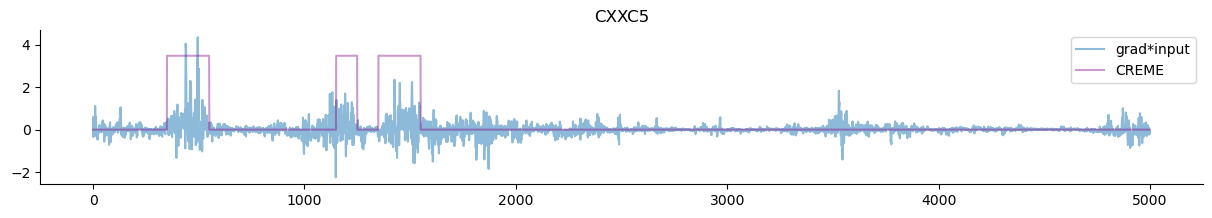

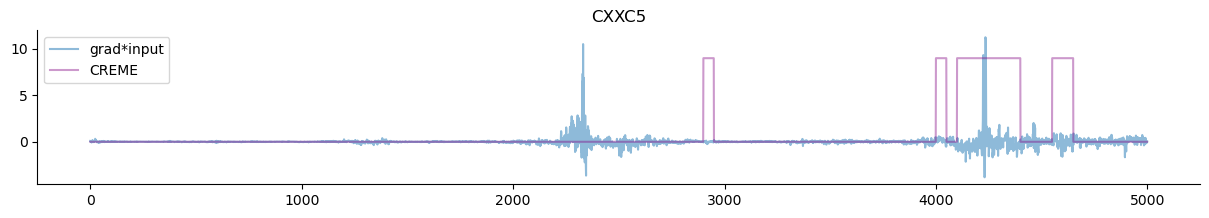

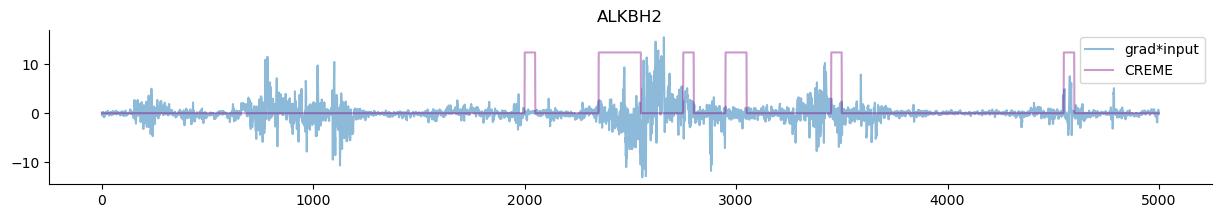

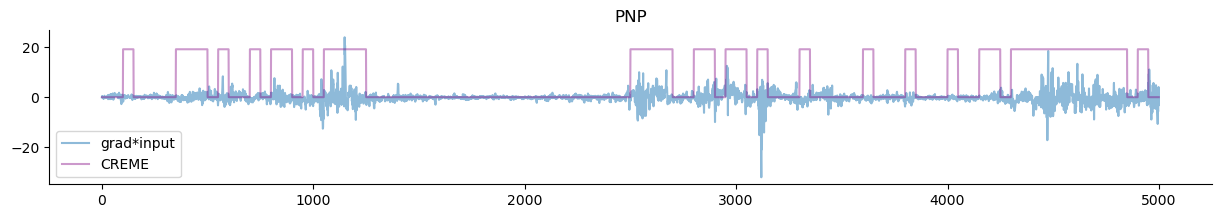

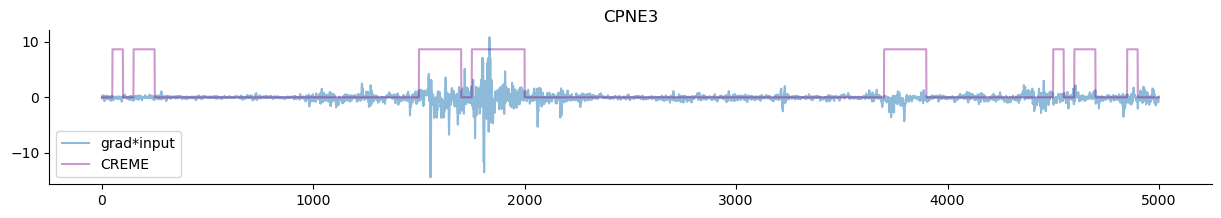

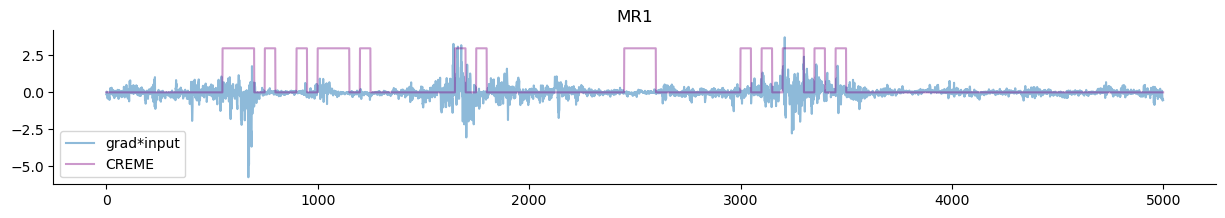

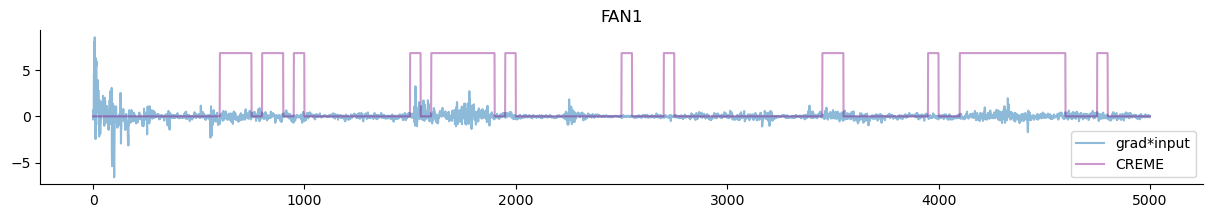

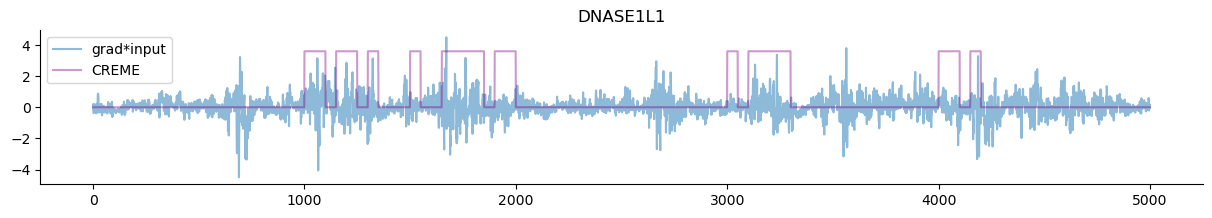

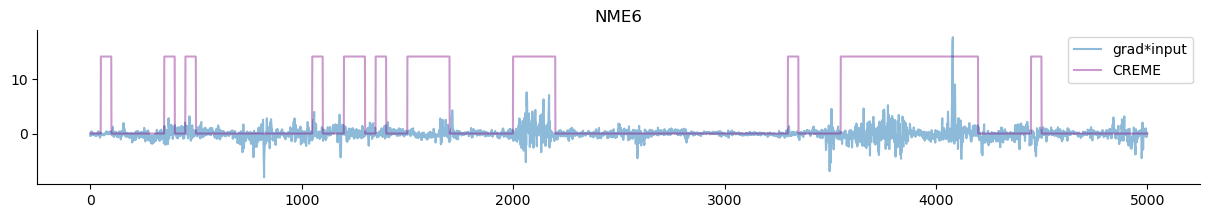

In [224]:
for filename in os.listdir('../results/saliency/5111/'):
    new_creme_mask = utils.plot_one_seq_feature_map(filename, model, seq_parser, 'K562', False)

In [156]:
np.sum(new_creme_mask)

10000.0

In [137]:
seq_tile_id = 'GATA2_chr3_128487916_-_100804_105804.pickle'
chrom, tss, strand, enh_tile_start = seq_tile_id.split('_')[1:5]
tss = int(tss)
enh_tile_start = int(enh_tile_start)
creme_res = utils.read_pickle(f'../results/motifs_500,50_batch_1,10_shuffle_10_thresh_0.9,0.7/K562/{seq_tile_id}')
saliency_res = utils.read_pickle(f'../results/saliency/5111/{seq_tile_id}')
mut_control = creme_res['mut']
xstreme_res = utils.read_pickle(glob.glob(f'../results/XSTREME/FIMO/K562_enhancers_*/{seq_tile_id}')[0])


In [55]:
prune_bps = np.array([5000-int(i) for i in [5000] + creme_res[500]['bps'][:-1] + creme_res[50]['bps']])
frac = np.array([1] + creme_res[500]['scores'][:-1] + creme_res[50]['scores'])
saliency_scores = saliency_res['saliency'] / mut_control

128490416

In [16]:
wt_seq = seq_parser.extract_seq_centered(chrom, int(tss), strand, model.seq_length)
wt_seq_padded = np.pad(wt_seq[np.newaxis].copy(),
                       ((0, 0), (model.seq_length // 2, model.seq_length // 2), (0, 0)), 'constant')
predictions = model.predict(wt_seq[np.newaxis])[0]
target_mask = np.zeros_like(predictions)
target_bins = [447, 448]
track_index = 5111
for idx in target_bins:
    target_mask[idx, track_index] = 1

saliency_scores = model.contribution_input_grad(wt_seq_padded, target_mask, mult_by_input=False).numpy()[0,
           model.seq_length // 2:-model.seq_length // 2, :]
saliency_times_input = model.contribution_input_grad(wt_seq_padded, target_mask, mult_by_input=True)[model.seq_length // 2:-model.seq_length // 2].numpy()

In [20]:
enh_tile_end = enh_tile_start + 5000
enh_saliency_times_input = saliency_times_input[enh_tile_start: enh_tile_end]

enh_saliency = saliency_scores[enh_tile_start:enh_tile_end]
saliency_df = utils.grad_times_input_to_df(wt_seq[enh_tile_start:enh_tile_end], enh_saliency)


In [51]:
bps = np.arange(0, 5001, 500)
saliency_positions = [l + enh_tile_start for l in np.argsort(saliency_times_input)]
target_bins = [447, 448]
track_index = 5111


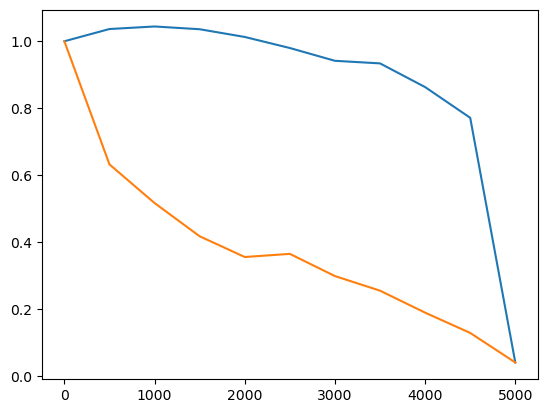

In [83]:
plt.plot(prune_bps, frac)
plt.plot(prune_bps, saliency_scores)


In [84]:
quantiles = [j/10 for j in range(1, 10, 1)]
saliency_thresholds = [np.quantile(enh_saliency_times_input, i) for i in quantiles]


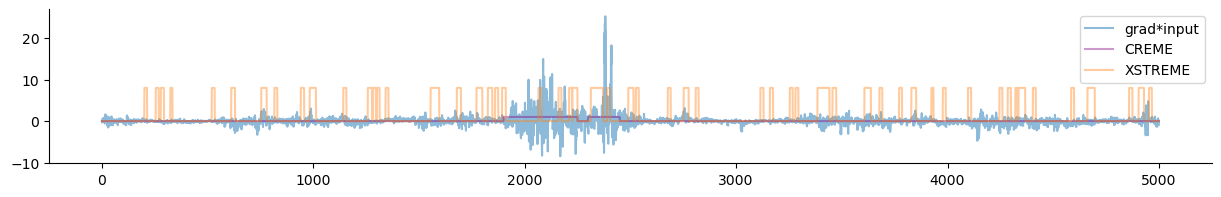

In [145]:
fig, ax = plt.subplots(1,1,figsize=[15, 2])
ax.plot(enh_saliency_times_input, alpha=0.5, label='grad*input')

creme_mask = np.zeros((5000,))
for interval in creme_res[50]['insert_coords']:
    interval = interval - enh_tile_start
    creme_mask[interval[0]: interval[1]] = 1
ax.plot(creme_mask, label='CREME', color='purple', alpha=0.4)
# plt.xlim(2000,2600)
ax.plot([8 if x else False for x in xstreme_res['motif_mask']], label='XSTREME', alpha=0.4)

ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [146]:
creme_mask.sum()

500.0

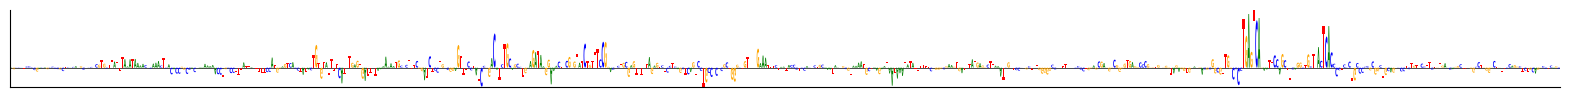

In [93]:
utils.plot_attribution_map(saliency_df[1900:2500])

In [101]:
hist_dir = '../data/biochemical_marks/K562/histone/'
metadata = pd.read_csv(f'{hist_dir}/metadata.csv')

In [105]:
import pyBigWig
bw_path = f"{hist_dir}/{metadata[metadata['Experiment target']=='H3K27ac-human']['File accession'].values[0]}.bigWig"
bw = pyBigWig.open(bw_path)


In [113]:
v = bw.values(chrom, tss - model.seq_length//2, tss + model.seq_length//2)


In [116]:
enh_tile_start

100804

(90000.0, 106000.0)

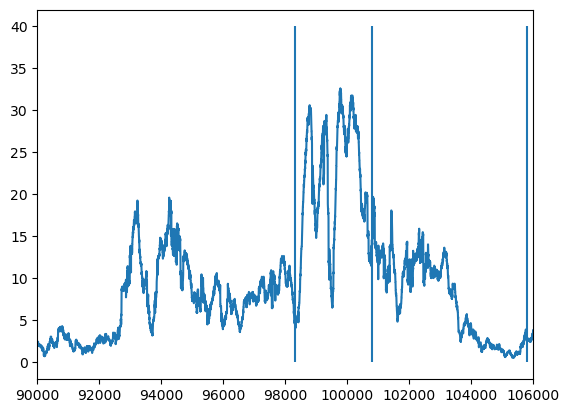

In [122]:
plt.plot(v)
plt.vlines(enh_tile_start, 0, 40)
plt.vlines(enh_tile_end, 0, 40)
plt.vlines(model.seq_length//2,  0, 40)
plt.xlim(90000,106000)

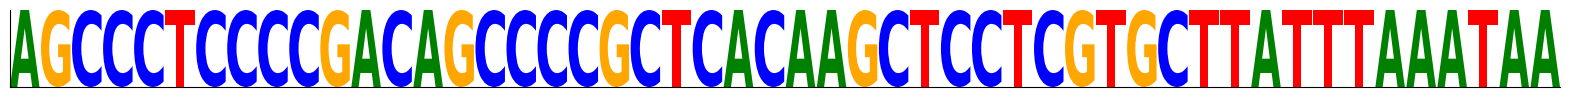

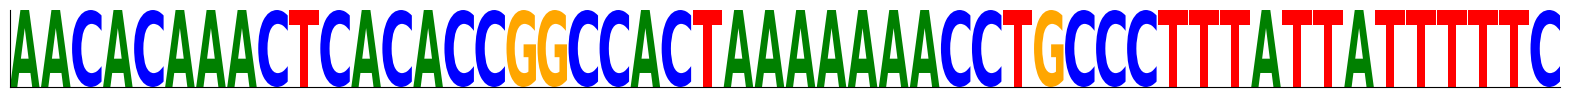

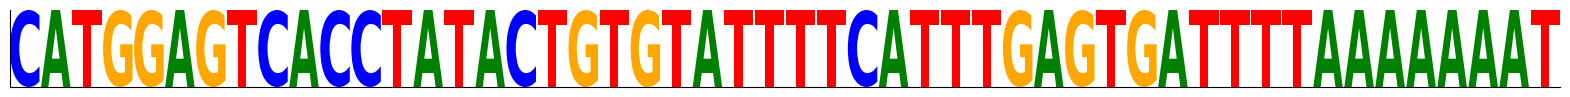

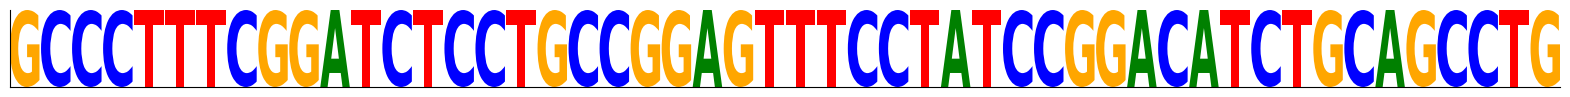

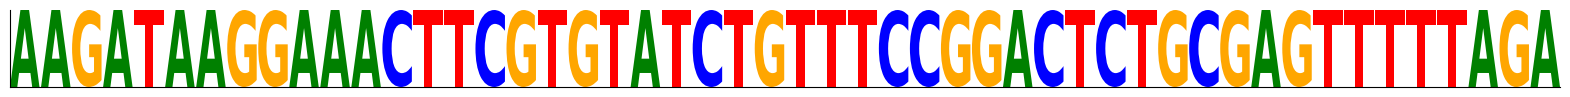

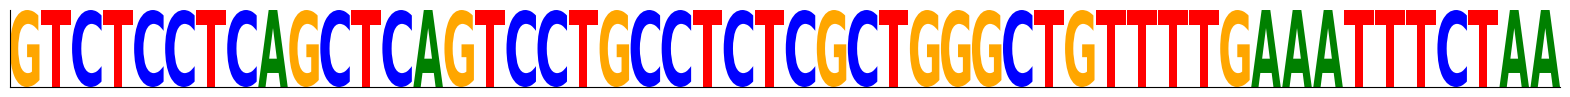

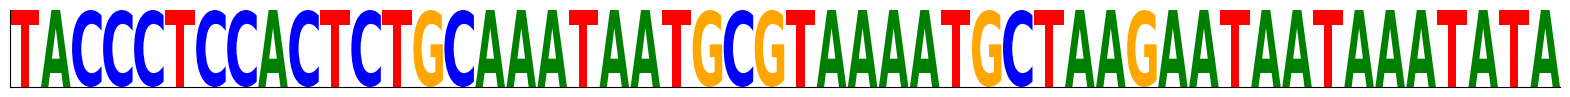

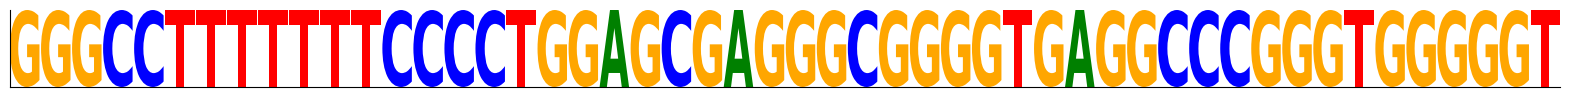

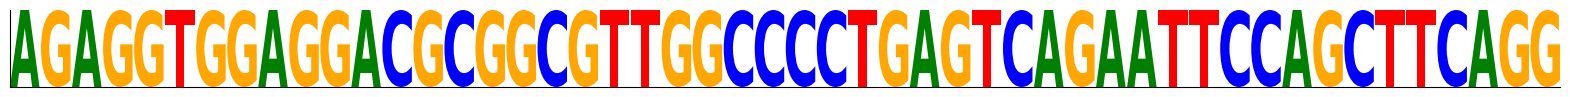

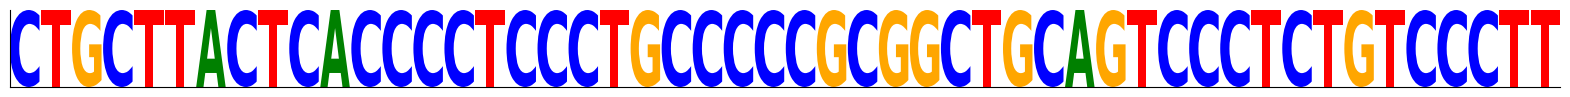

In [200]:
for s, e in creme_res[50]['insert_coords']:
    plot_attribution_map(pd.DataFrame(wt_seq[s:e], columns=['A', 'C', 'G', 'T']))

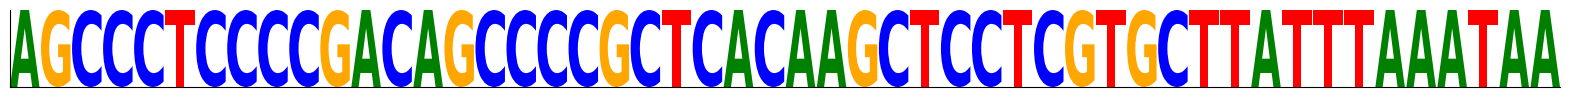

In [199]:
plot_attribution_map(pd.DataFrame(wt_seq[102704:102754], columns=['A', 'C', 'G', 'T']))

In [221]:
int(tss) - model.seq_length + s

128394512

In [235]:
wt_seq_str[103204:103254]

'CTGCTTACTCACCCCTCCCTGCCCCCGCGGCTGCAGTCCCTCTGTCCCTT'

In [223]:
creme_res[50]['insert_coords']

[array([102704, 102754]),
 array([102754, 102804]),
 array([102804, 102854]),
 array([102854, 102904]),
 array([102904, 102954]),
 array([102954, 103004]),
 array([103004, 103054]),
 array([103104, 103154]),
 array([103154, 103204]),
 array([103204, 103254])]

In [225]:
wt_seq[103204]

array([0., 1., 0., 0.], dtype=float32)

In [218]:
tss_positions[tss_positions['gene_name']=='GATA2']

128487916+9500

128497416

In [56]:
tss = 209806142 + (209806175 - 209806142) //2

In [57]:
wt_seq = seq_parser.extract_seq_centered('chr1', tss, '-', model.seq_length)

In [52]:
enhancer_region = ["chr1", 209815790, 209816390]

In [58]:
wt_pred = model.predict(wt_seq)

2024-02-04 13:18:25.732678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-04 13:18:25.831004: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


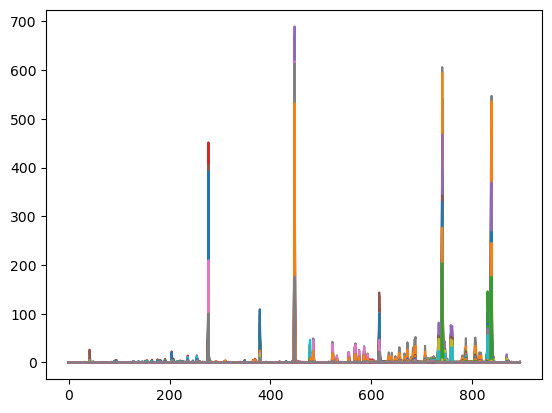

In [74]:
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
df_mask = []
for d in target_df['description']:
    if 'CAGE' in d:
        df_mask.append(True)
    else:
        df_mask.append(False)
cage_indeces = target_df[df_mask]['index'].values

In [113]:
active_cells = cage_indeces[np.argwhere(wt_pred[0,447:449,cage_indeces].mean(axis=-1) > 50).flatten()]

In [111]:
# plt.plot(wt_pred[0,:,cage_indeces[active_cells]].T, alpha=0.3);
enh_start = enhancer_region[1]  - (tss - model.seq_length // 2)
enh_end = enhancer_region[2] - (tss - model.seq_length // 2) 
enh_center = enh_start + (enh_end - enh_start) // 2
enh_start = enh_center - 2500
enh_end = enh_center + 2500

In [121]:
pred_shuffle = []
num_shuffle = 10
for n in range(num_shuffle):
    x_mut = np.copy(wt_seq)

    # shuffle tile
    x_mut[enh_start:enh_end,:] = shuffle.dinuc_shuffle(x_mut[enh_start:enh_end,:])
    # all_muts[tile_i, n, :, :] = x_mut
    # predict mutated sequence
    pred_shuffle.append(model.predict(x_mut[np.newaxis])[0])


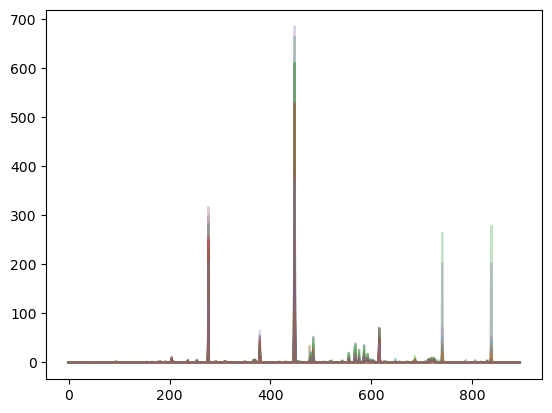

In [127]:
mean_mutant = np.array(pred_shuffle).mean(axis=0)
plt.plot(mean_mutant[:, active_cells], alpha=0.3);

In [139]:
tss_wt = wt_pred[0,:, active_cells][:, [447, 448]].mean(axis=-1)
tss_pred = mean_mutant[447:449, active_cells].mean(axis=0)

In [140]:
(tss_wt - tss_pred) / tss_wt

array([0.01464374, 0.01438167, 0.02481163, 0.07945096, 0.03083506,
       0.02700114, 0.05146605, 0.0034025 , 0.02637965, 0.07674662,
       0.03172186, 0.0423628 , 0.01556312, 0.02250559, 0.03689528,
       0.0123386 , 0.05171139, 0.0191766 , 0.02400013, 0.01571728,
       0.0458875 , 0.02335095, 0.01467459, 0.01273902, 0.02432914,
       0.01503598, 0.05079319, 0.00539479, 0.0048884 , 0.06006305,
       0.00611409, 0.06001858, 0.00785276, 0.00438022, 0.00599408,
       0.00465438, 0.00559323, 0.00581412, 0.02495828, 0.03580542,
       0.01966459, 0.05366829, 0.03288217, 0.04611965, 0.06425496,
       0.0323077 , 0.06143022, 0.04607001, 0.02686235, 0.0218438 ,
       0.00858731, 0.01636155, 0.0091446 , 0.01669056, 0.02081336,
       0.01886091, 0.00635857, 0.00871734, 0.00677229, 0.00966114,
       0.00689263, 0.01970052, 0.03480434, 0.01239647, 0.04795975,
       0.05982594, 0.02177793, 0.01844137, 0.01186681, 0.03747599,
       0.02906347, 0.01593705, 0.02191175, 0.02058494, 0.02010

In [ ]:
creme.prune_sequence(model, wt_seq, control_sequences, mut, whole_tile_start, whole_tile_end, scales, thresholds, frac,
                   N_batches, cre_type='enhancer')